### Exploration of Evaluation

In [27]:
import torch
import os

import numpy as np
import pandas as pd

from collections import OrderedDict

from src.data.dataloader import get_loaders
from src.models.model import get_model, PredictiveEncoder
from src.evaluation.figures import plot_marginal_frequency
from src.evaluation.pruning import prune_encoder_, pruning_status
from src.models.test import predict, run_inference

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix, balanced_accuracy_score
from codecarbon import EmissionsTracker
from memory_profiler import memory_usage

In [3]:
# plot style
plt.style.use('ggplot')
plt.rcParams['lines.linewidth'] = 3
sns.set(font_scale=1.5)

colors = ['C0', 'C1', 'C2', 'C3', 'C4']

In [4]:
experiment_name = 'test' # 'PredConvAE.lr=1e4.bz=32.seed=42'
device          = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load stored checkpoint
checkpoint = torch.load(f'../../models/{experiment_name}/best.ckpt')
encoder_state_dict = OrderedDict({layer_: weights_ for (layer_, weights_) in checkpoint['state_dict'].items() if 'decoder' not in layer_})

# Load pre-trained model
model, _, _, _ = get_model(model_name=checkpoint['model']['name'], device=device)
model.load_state_dict(checkpoint['state_dict'])
model.eval()

print("Model loaded !")
print(f"Device: {device}")

print(f"\nEncoder parameters: \t\t{sum(param_.numel() for param_ in model.encoder.parameters()) + sum(param_.numel() for param_ in model.encoder_fc.parameters()) + sum(param_.numel() for param_ in model.latent_classifier.parameters())}")
print(f"Decoder parameters: \t\t{sum(param_.numel() for param_ in model.decoder.parameters()) + sum(param_.numel() for param_ in model.decoder_fc.parameters())}")
print(f"Total number of parameters: \t{sum(param_.numel() for param_ in model.parameters())}")

Model loaded !
Device: cpu

Encoder parameters: 		403301
Decoder parameters: 		187075
Total number of parameters: 	590376


In [5]:
encoder = PredictiveEncoder().to(device)
encoder.load_state_dict(encoder_state_dict)
encoder.eval()

print("Model loaded !")
print(f"Encoder parameters: {sum(param_.numel() for param_ in encoder.parameters())}")

Model loaded !
Encoder parameters: 403301


In [6]:
# Load data
loaders, mu, sigma = get_loaders(
    data_path = '../../data',
    balancing_strategy='downsample',
    batch_size=checkpoint['training_parameters']['batch_size'],
    shuffle=True,
    val_size=0.2,
    seed=checkpoint['seed'],
)

In [7]:
latent_representations_train, pred_train, prob_train, ttrain, eq_train  = run_inference(loaders['train'], encoder, device=device)
latent_representations_val, pred_val, prob_val, tval, eq_val            = run_inference(loaders['val'], encoder, device=device)
latent_representations_test, pred_test, prob_test, _, _                 = run_inference(loaders['test'], encoder, device=device)

100%|███████████████████████████████████████████| 84/84 [00:33<00:00,  2.53it/s]


In [8]:
from sklearn.metrics import recall_score, roc_auc_score

In [9]:
print(f"\nTrain accuracy: {eq_train.mean()}")
print(f"Validation accuracy: {eq_val.mean()}")

print(f"\nTrain balanced accuracy: {balanced_accuracy_score(ttrain, pred_train)}")
print(f"Validation balanced accuracy: {balanced_accuracy_score(tval, pred_val)}")

print(f"\nTrain recall: {recall_score(ttrain, pred_train, average='weighted')}")
print(f"Validation recall: {recall_score(tval, pred_val, average='weighted')}")

print(f"\nTrain auc: {roc_auc_score(ttrain, prob_train, multi_class='ovr')}") # one-vs-rest
print(f"Validation auc: {roc_auc_score(tval, prob_val, multi_class='ovr')}") # one-vs-rest


Train accuracy: 0.7284507042253521
Validation accuracy: 0.7018339950841369

Train balanced accuracy: 0.7284507042253521
Validation balanced accuracy: 0.6957726936131416

Train recall: 0.7284507042253521
Validation recall: 0.7018339950841369

Train auc: 0.9267558520134894
Validation auc: 0.9191926058961032


#### Utility functions - decision theory

***Note:*** I have used normalization by row (the true class) as the confusion matrix then presents the recall score. This means that it tells us something about how many of the actually positive samples our model predict, i.e. we see if the model is not capable of capturing the actual class. This is important as we do not want to make errors on certain classes - e.g. the alarm.

In [10]:
results = {
    'train': {
        'labels': ttrain,
        'preds': pred_train,
        'probs': prob_train,
        'z': latent_representations_train,
    },
    'validation': {
        'labels': tval,
        'preds': pred_val,
        'probs': prob_val,
        'z': latent_representations_val,
    },
    'test': {
        'labels': None,
        'preds': pred_test,
        'probs': prob_test,
        'z': latent_representations_test,
    }
}

U = np.identity(5)

model_name = checkpoint['model']['name']

In [11]:
def compute_calibration_curve(targets, probs, num_bins=10):

    bins = np.linspace(0, 1, num_bins+1)

    p_true_mean, p_true_se, p_pred = [], [], []

    for i in range(num_bins):
        bin_start, bin_end = bins[i], bins[i+1]
        bin_center = 0.5*(bin_start + bin_end)
        
        bin_idx = np.logical_and(bin_start <= probs, probs < bin_end)
        num_points_in_bin = np.sum(bin_idx)
        
        if len(targets[bin_idx]) == 0:
            continue

        p_pred.append(bin_center)
        p_est = np.mean(targets[bin_idx])
        p_true_mean.append(p_est)
        p_true_se.append(np.sqrt(p_est*(1-p_est)/num_points_in_bin))
        
    return np.array(p_true_mean), np.array(p_true_se), np.array(p_pred)
    
def visualize_results(results, U, model_name):
     
    # computing the expected utility for each class
    EU_train = prob_train @ U
    EU_val = prob_val @ U

    # not one hot
    U_ttrain = EU_train.argmax(axis=1)
    U_tval = EU_val.argmax(axis=1)

    idx2label   = {0: 'Other', 1: 'Music', 2: 'Human voice', 3: 'Engine sounds', 4: 'Alarm'}

    combinations = [
        (results['train']['labels'], U_ttrain, 'Train - Precision'), 
        (results['train']['labels'], U_ttrain, 'Train - Recall'),
        (results['validation']['labels'], U_tval, 'Validation - Precision'),
        (results['validation']['labels'], U_tval, 'Validation - Recall'),
    ]

    for target_, pred_, title_ in combinations:
        # plot everything
        fig, axes = plt.subplots(1, 2, figsize=(20, 8))

        # utility matrix
        visualize_utility(axes[0], U, labels=idx2label.values())

        # plotting the new confusion matrix
        cm = confusion_matrix(target_, pred_, normalize=('true' if 'recall' in title_.lower() else 'pred'))
        fig, axes[1] = visualize_confusion_matrix(fig, axes[1], cm, model_name, title_)

        fig.subplots_adjust(wspace=0.4)
        plt.show()
    
    for dtype in ['train', 'validation', 'test']:
        fig, axs = plt.subplots(1, 5, sharex=True, sharey=True, figsize=(18, 4))
        for i in range(5):
            axs[i].hist(results[dtype]['probs'][:, i], density=True, color=colors[i], label=idx2label[i])
            axs[i].legend()

        plt.xlim(-0.1, 1.1)
        fig.suptitle(f'{dtype.upper()} - Probability score distribution per category')
        plt.show()

    for dtype in ['train', 'validation']:
        fig, axes = plt.subplots(1, 5, figsize=(28, 4))
        for class_idx in range(5):
            ax = axes.flatten()[class_idx]
            p_true_mean, p_true_se, p_pred = compute_calibration_curve(results[dtype]['labels']==class_idx, results[dtype]['probs'][:, class_idx])
            ax.errorbar(p_pred, p_true_mean, p_true_se, label=idx2label[class_idx], color=colors[class_idx], marker='o', markersize=8)
            ax.plot([0, 1], [0, 1], 'k-', alpha=0.4)
            ax.legend(loc='upper left')
    
            ax.set_xlabel('Predicted probability')
        axes[0].set_ylabel('True probability')

        fig.subplots_adjust(wspace=0.1)
        fig.suptitle(f'{dtype.upper()} - Calibration curves')
        plt.show()

NameError: name 'visualize_utility' is not defined

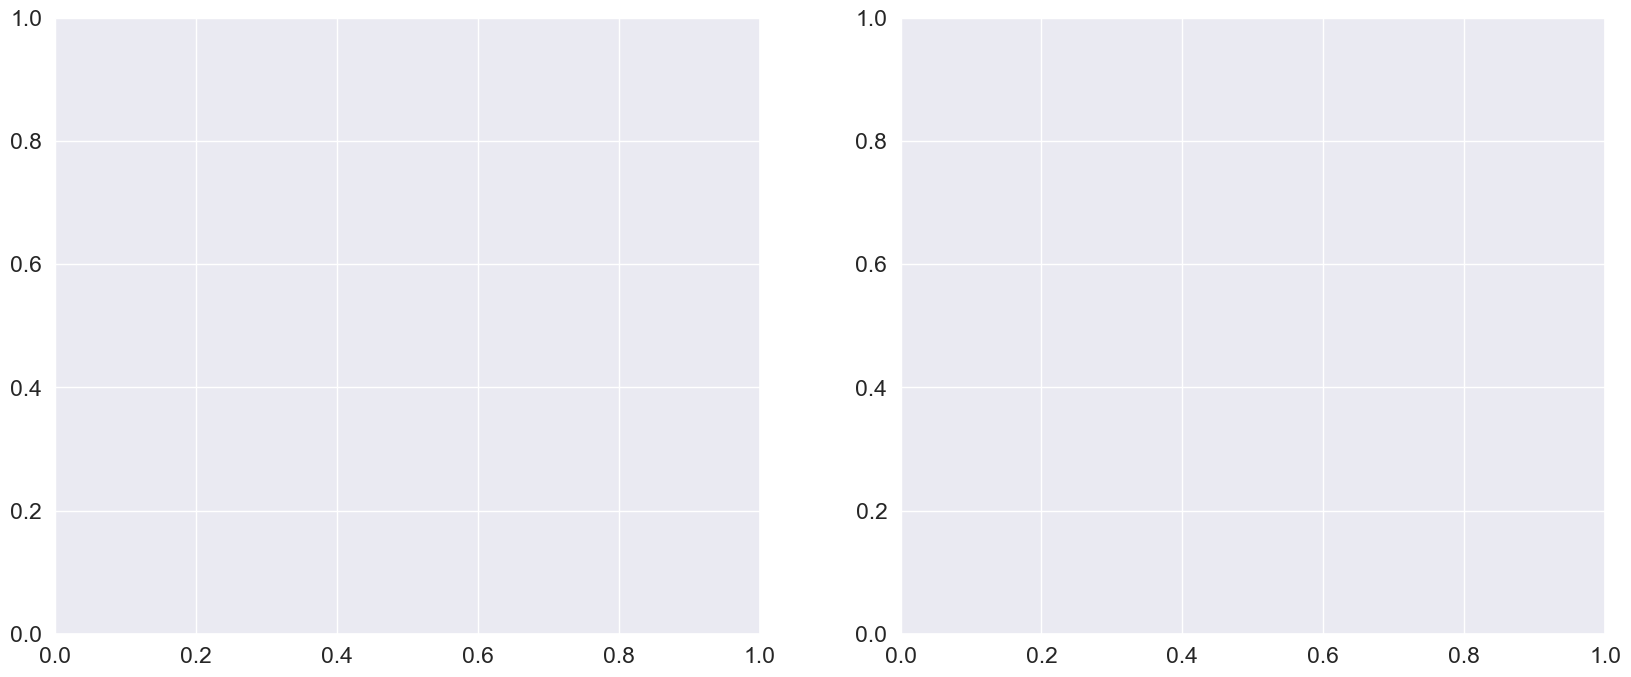

In [12]:
visualize_results(results, U, model_name)

### Analyzing the latent space

In [13]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

def visualize_latent_space(results, n_PCA_components=4):
        
    idx2label   = {0: 'Other', 1: 'Music', 2: 'Human voice', 3: 'Engine sounds', 4: 'Alarm'}

    
    pca = PCA(n_components=n_PCA_components)
    pca_train = pca.fit_transform(results['train']['z'], results['train']['labels'])

    fig, axs = plt.subplots(n_PCA_components, n_PCA_components, sharex=True, sharey=True, figsize=(10, 10))
    for row in range(n_PCA_components):
        for col in range(n_PCA_components):
            for i in range(5):
                proj_ = pca_train[results['train']['labels'] == i, :]
                axs[row, col].scatter(proj_[:, row], proj_[:, col], s=0.5, alpha=0.5, label = idx2label[i])
            
            if row == n_PCA_components - 1:
                axs[row, col].set_xlabel(f'PC{col+1}')
            if col == 0:
                axs[row, col].set_ylabel(f'PC{row+1}')

    # plt.legend()
    fig.suptitle(f"TRAIN - PCA")
    plt.show()

    for dtype in ['validation', 'test']:
        pca_proj = pca.transform(results[dtype]['z'])

        fig, axs = plt.subplots(n_PCA_components, n_PCA_components, sharex=True, sharey=True, figsize=(10, 10))
        for row in range(n_PCA_components):
            for col in range(n_PCA_components):
                
                if dtype == 'test':
                    axs[row, col].scatter(pca_proj[:, row], pca_proj[:, col], s=0.5, alpha=0.5, label = 'unknown')

                else:
                    for i in range(5):
                        proj_ = pca_proj[results[dtype]['labels'] == i, :]
                        axs[row, col].scatter(proj_[:, row], proj_[:, col], s=0.5, alpha=0.5, label = idx2label[i])
                
                if row == n_PCA_components - 1:
                    axs[row, col].set_xlabel(f'PC{col+1}')
                if col == 0:
                    axs[row, col].set_ylabel(f'PC{row+1}')

        # plt.legend()
        fig.suptitle(f"{dtype.upper()} - PCA")
        plt.show()
        
    for dtype in ['train', 'validation', 'test']:
        tsne = TSNE(n_components=2)
        projection = tsne.fit_transform(results[dtype]['z'], results[dtype]['labels'])

        plt.figure(figsize=(10, 10))
        if dtype == 'test':
            plt.scatter(projection[:, 0], projection[:, 1], alpha=0.5, label='unknown')
        else:
            for i in range(5):
                proj_ = projection[results[dtype]['labels'] == i, :]
                plt.scatter(proj_[:, 0], proj_[:, 1], alpha=0.5, label = idx2label[i])
        
        plt.title(f'{dtype.upper()} - tSNE projection')
        plt.legend()
        plt.show()

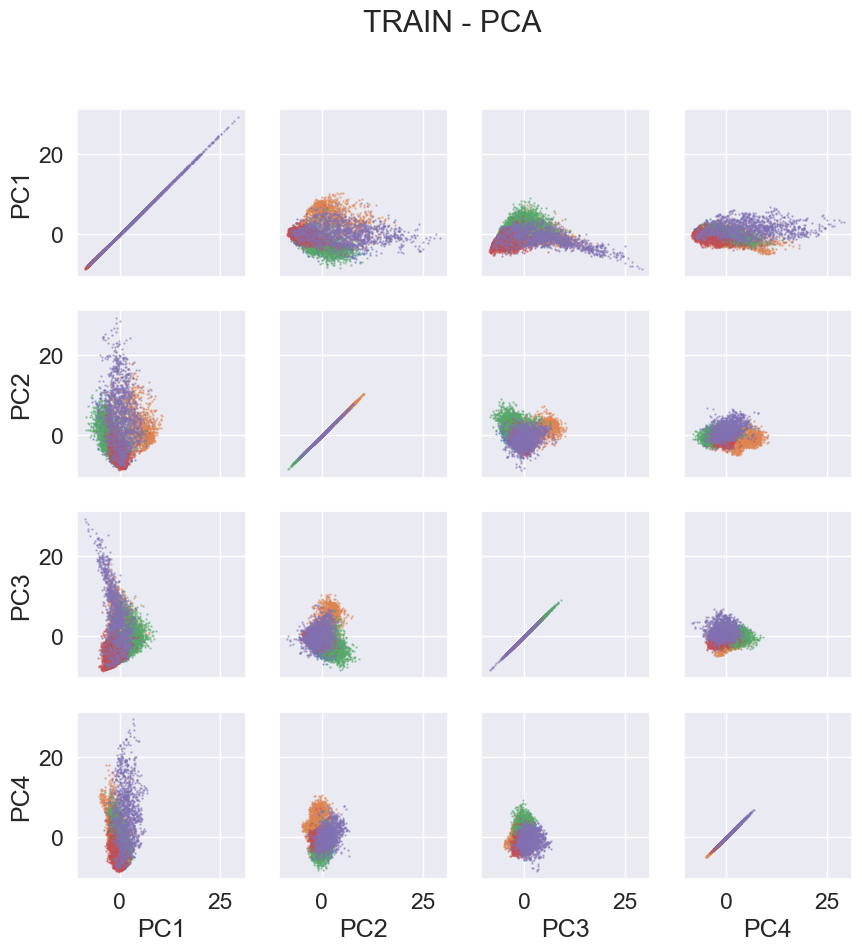

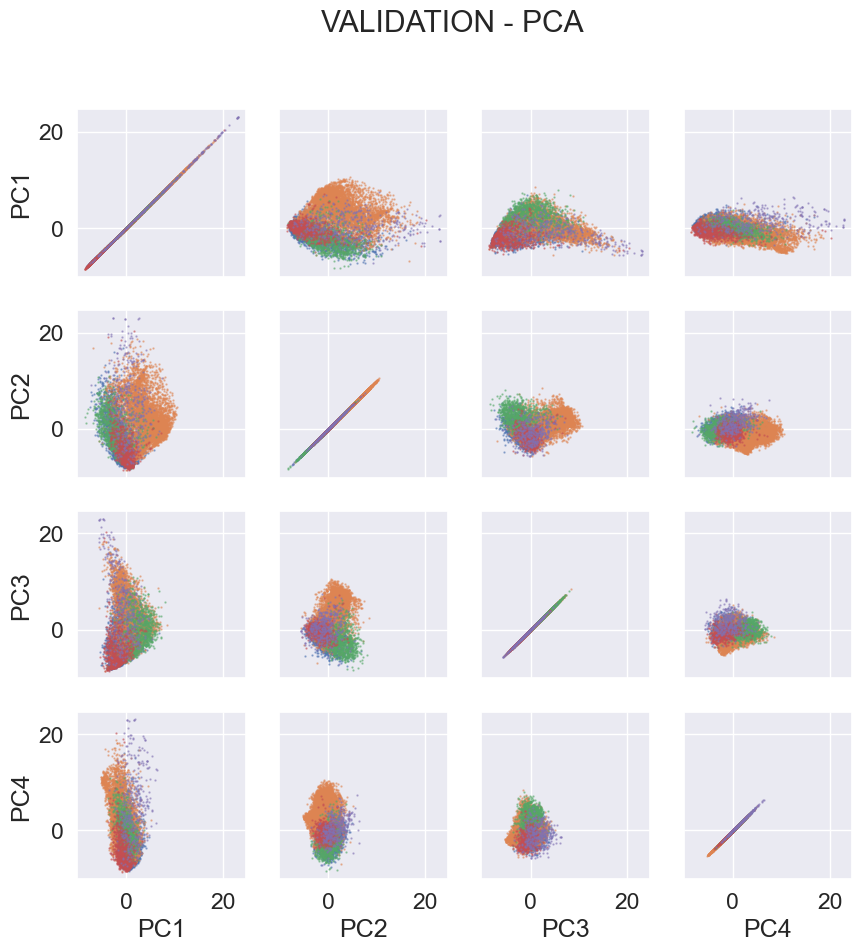

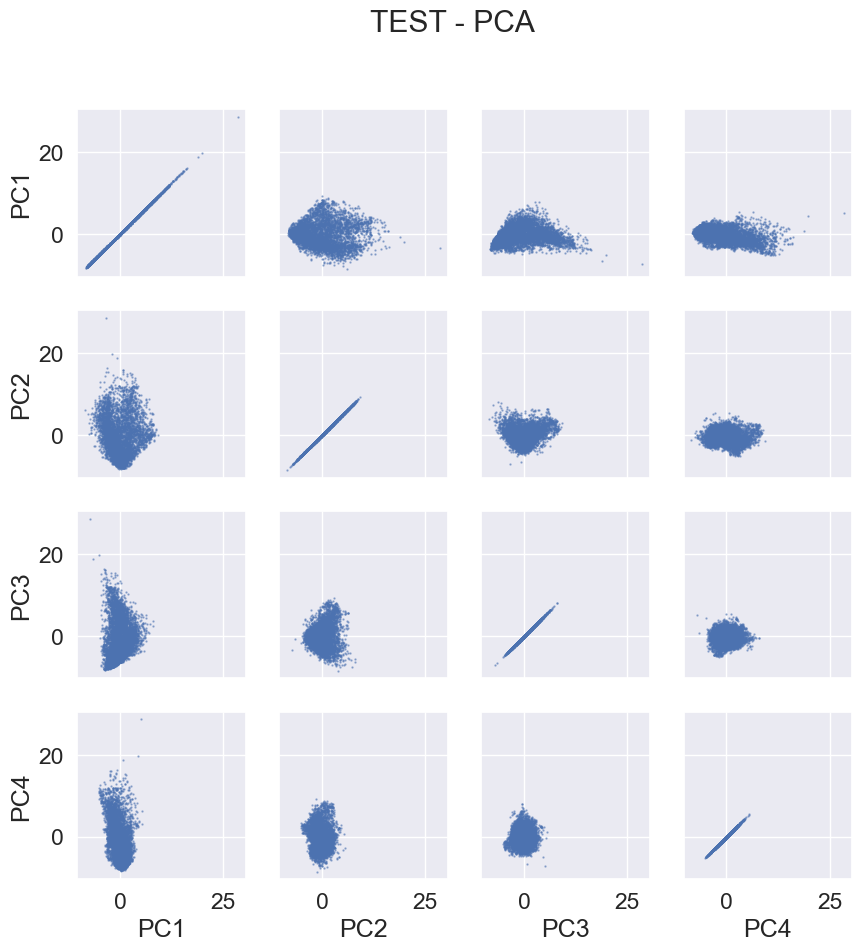

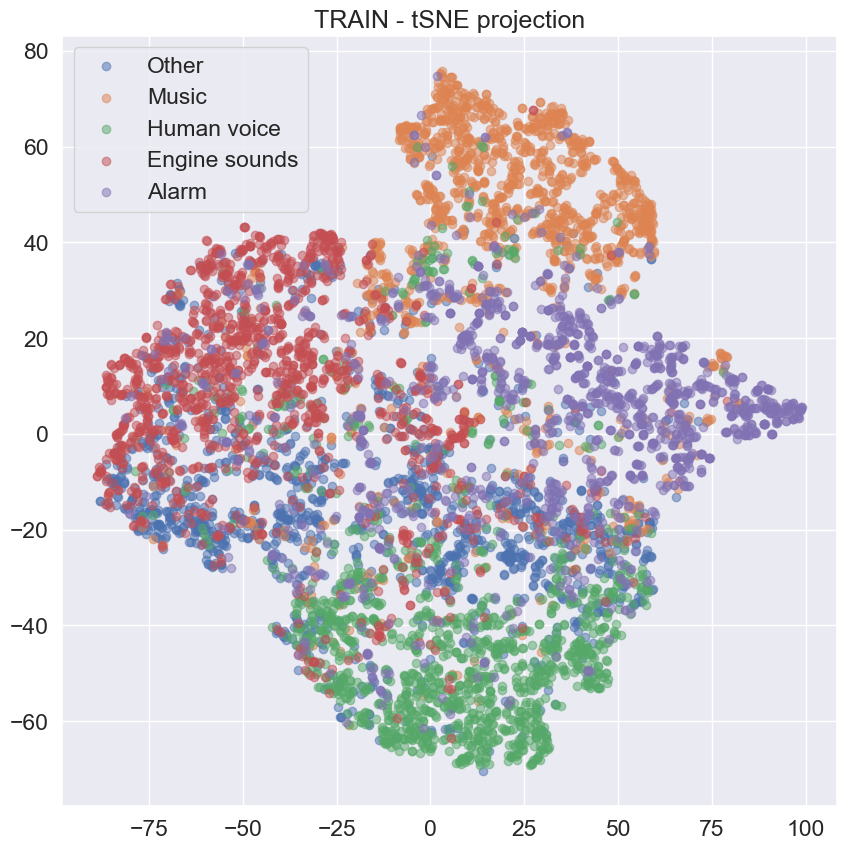

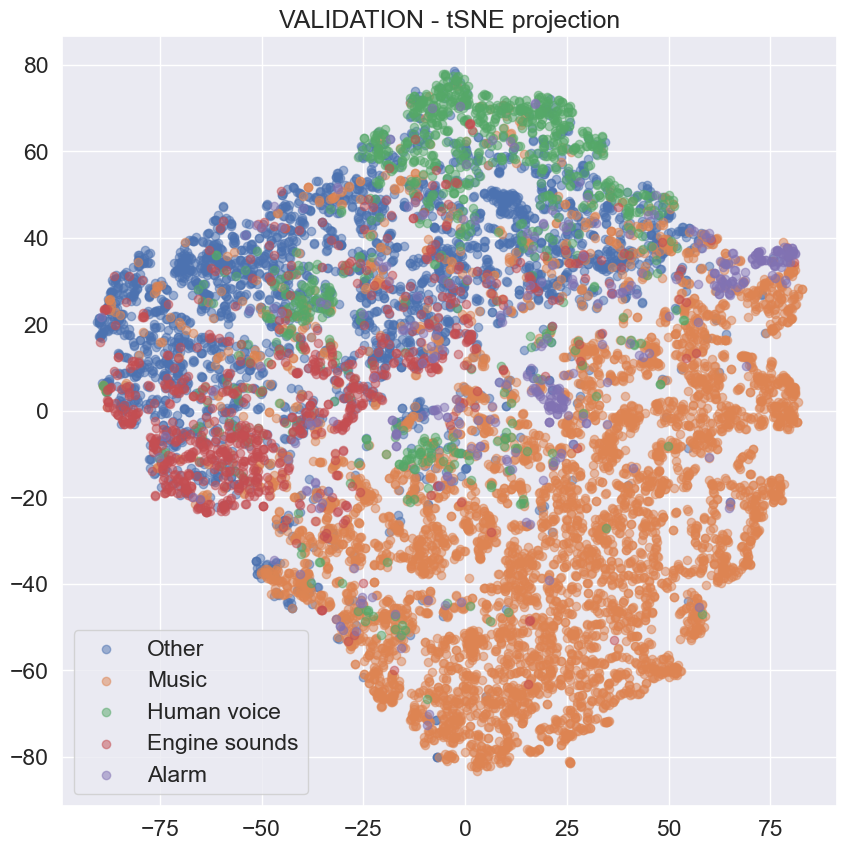

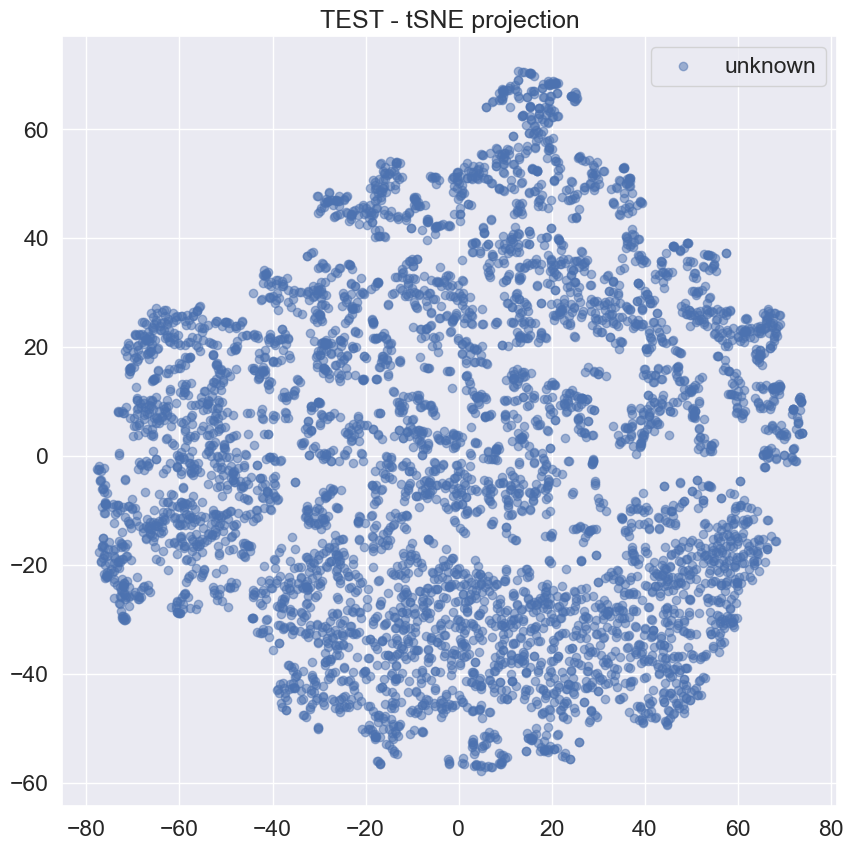

In [14]:
visualize_latent_space(results)

### Visualize stats-ish

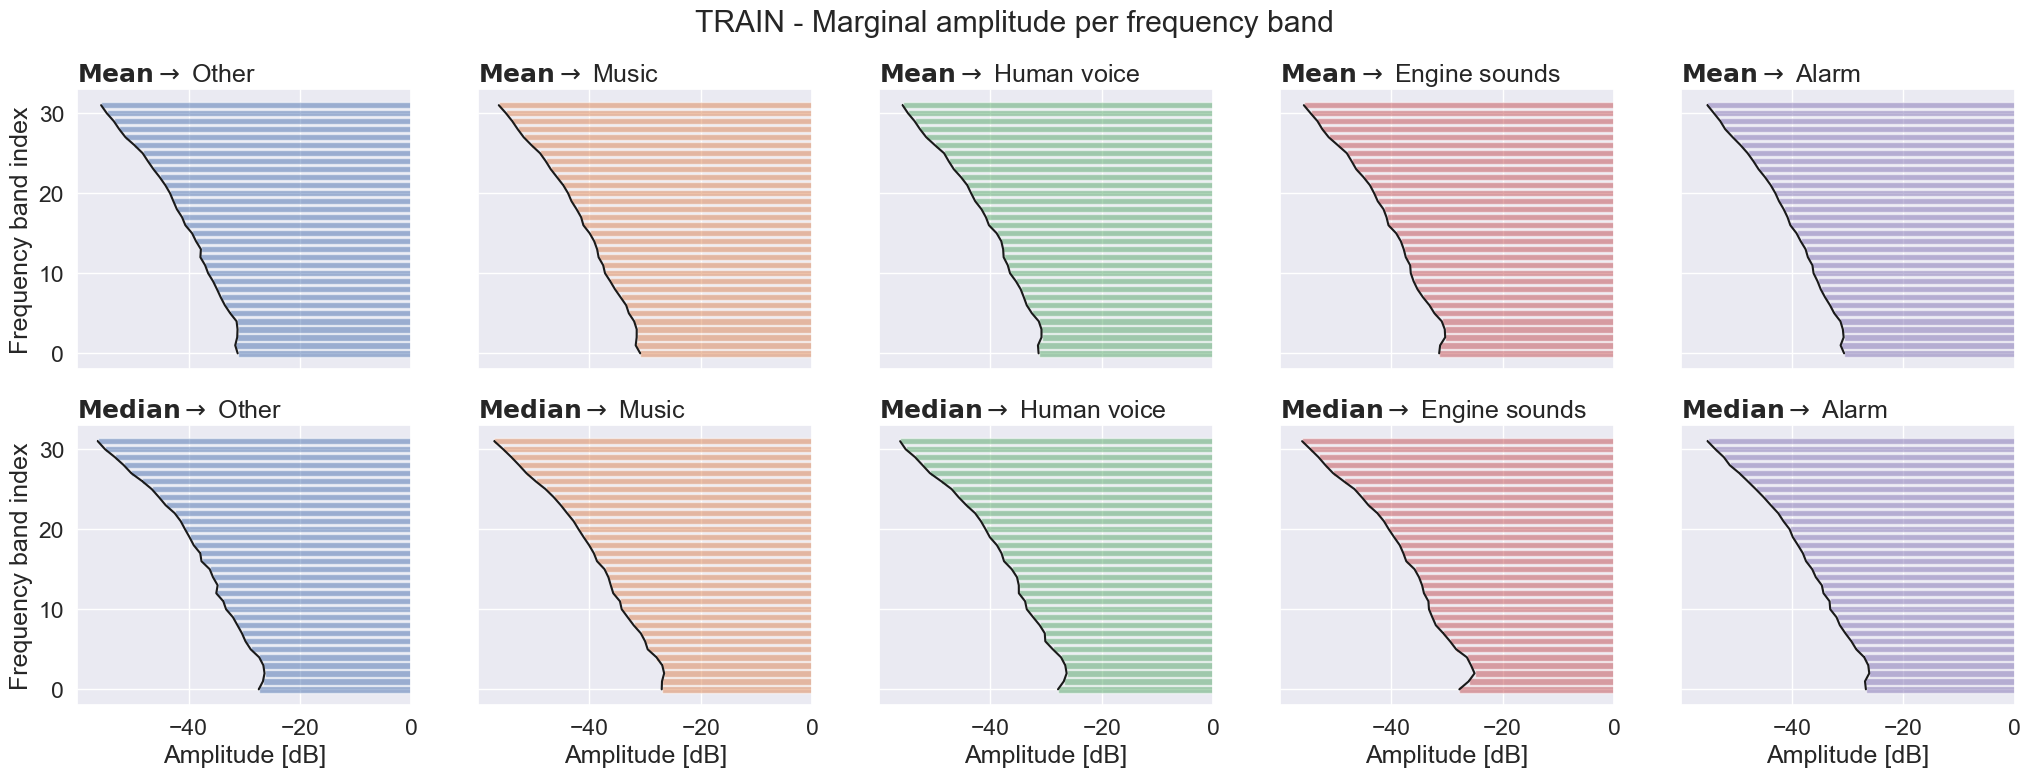

In [15]:
Xtrain = []
for batch in iter(loaders['train']):
    Xtrain.append(batch['data'])
Xtrain = np.vstack(Xtrain)

fig = plot_marginal_frequency(Xtrain.squeeze(1) * sigma + mu, results['train']['labels'], num_classes=5)
fig.suptitle('TRAIN - Marginal amplitude per frequency band')
plt.show()

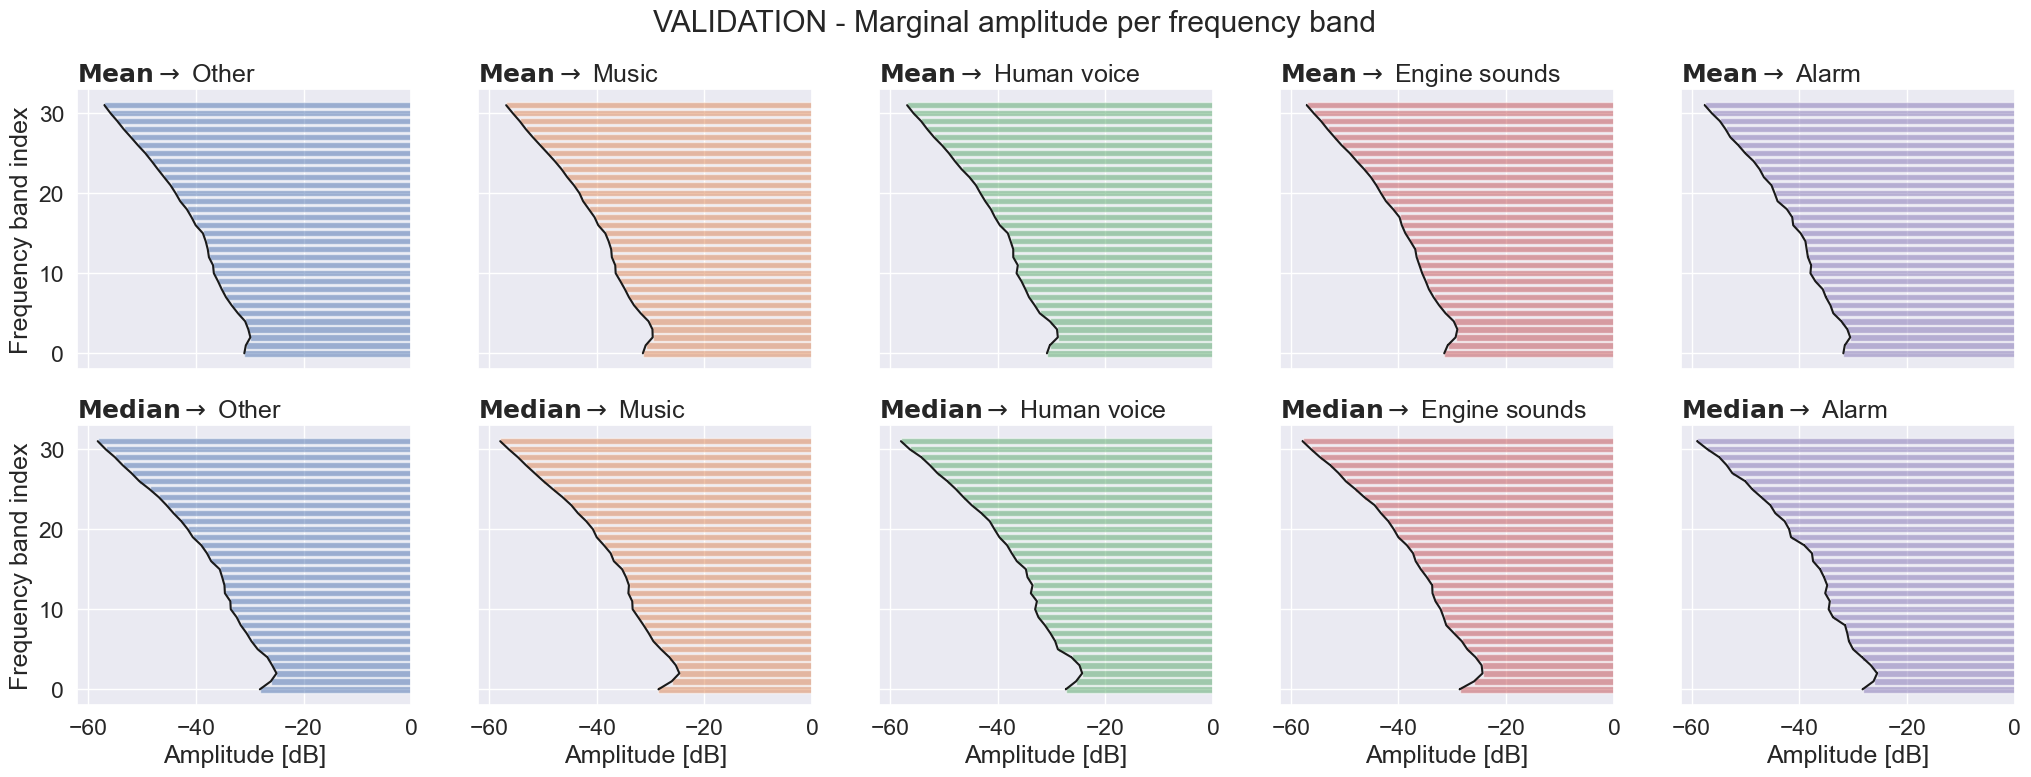

In [16]:
Xval = []
for batch in iter(loaders['val']):
    Xval.append(batch['data'])
Xval = np.vstack(Xval)

fig = plot_marginal_frequency(Xval.squeeze(1) * sigma + mu, results['validation']['labels'], num_classes=5)
fig.suptitle('VALIDATION - Marginal amplitude per frequency band')
plt.show()

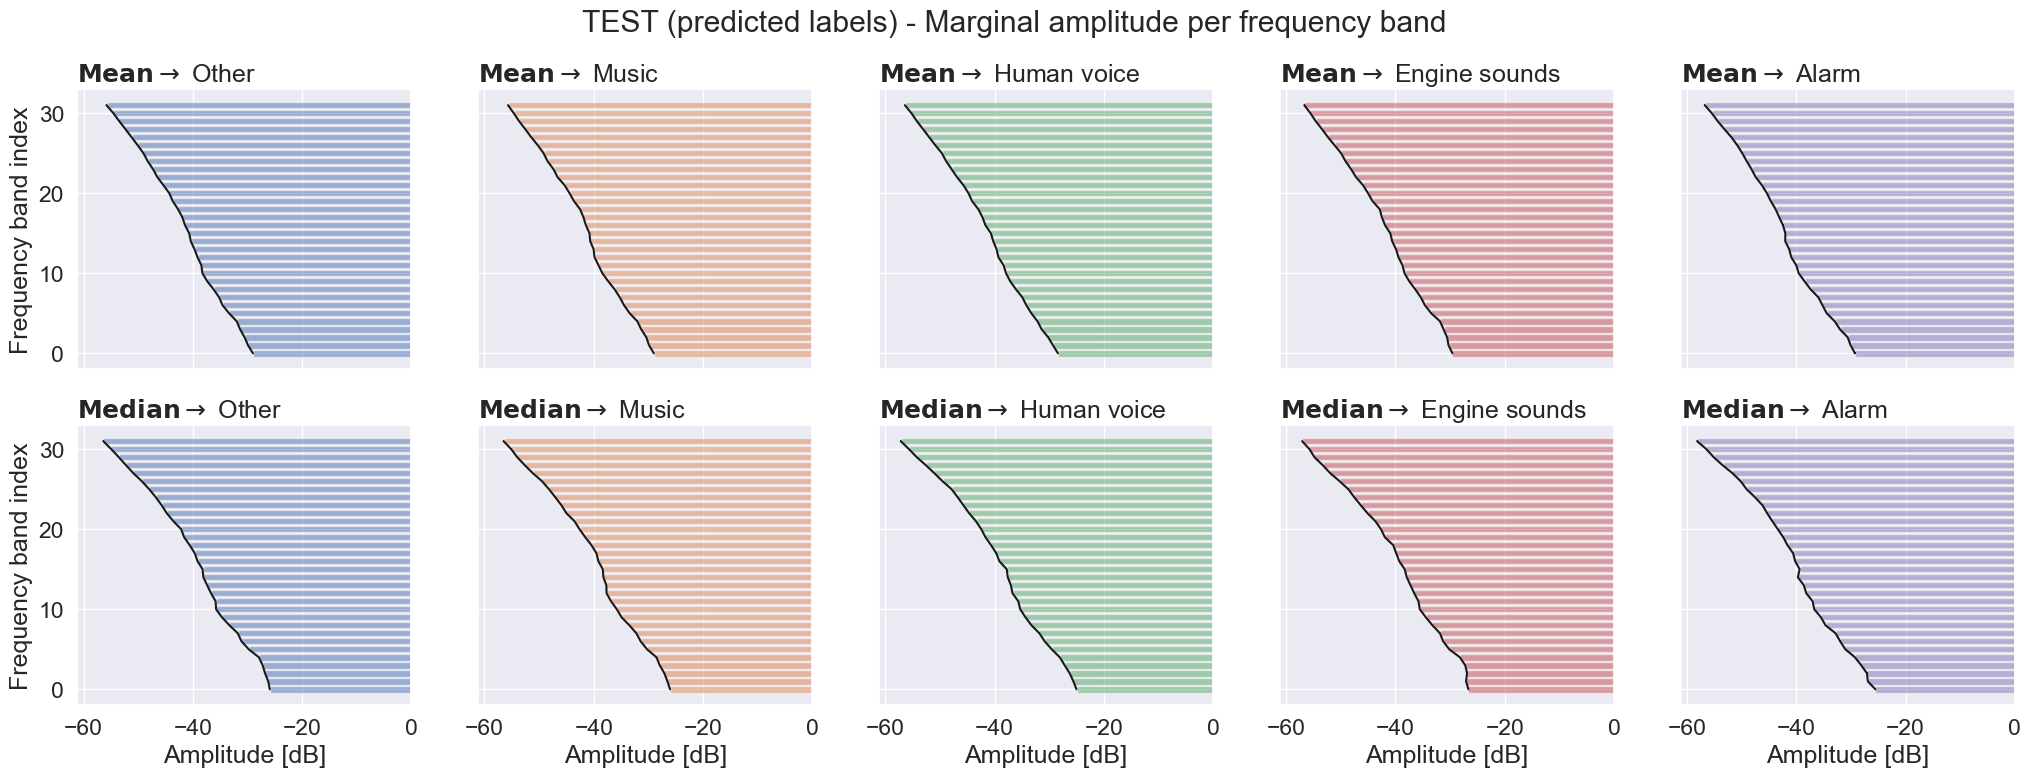

In [17]:
Xtest = []
for batch in iter(loaders['test']):
    Xtest.append(batch['data'])
Xtest = np.vstack(Xtest)

fig = plot_marginal_frequency(Xtest.squeeze(1) * sigma + mu, results['test']['preds'], num_classes=5)
fig.suptitle('TEST (predicted labels) - Marginal amplitude per frequency band')
plt.show()

### Evaluate pruning and hardware-related performance

In [95]:
from tqdm.notebook import tqdm

def run_inference_with_computational_metrics(loader, model, device):
    latent_representations, predictions, equals, all_targets, probs = [], [], [], [], []
    memory_usage_data = []

    try:
        os.remove("emissions.csv")
    except:
        None
        
    tracker = EmissionsTracker()
    
    with torch.no_grad():
        for batch in tqdm(iter(loader)):
        
            x       = batch['data'].to(device)
            targets = batch['label'].to(device).to(torch.long)

            tracker.start()
            outputs = model(x)
            memory_usage_data.append(memory_usage()[-1])
            tracker.stop()

            # Store latent representations
            latent_representations.append(outputs['z'].cpu())

            # Store predictions
            preds = outputs['t_logits'].argmax(axis=1)
            predictions.append(preds)
            equals.append(torch.tensor(preds.cpu().numpy() == targets.cpu().numpy()))

            # Store probabilities
            probs.append(outputs['t_logits'].softmax(dim=1)) 

            # Store targets
            all_targets.append(targets)

        computational_metrics = pd.read_csv('emissions.csv')[[
            'timestamp', 'project_name', 'duration', 
            'emissions', 'emissions_rate', 
            'cpu_power', 'gpu_power', 'ram_power', 
            'cpu_energy', 'gpu_energy', 'ram_energy', 'energy_consumed', 
            'os', 'python_version', 
            'cpu_count', 'cpu_model', 'gpu_count', 'gpu_model', 
            'ram_total_size'
        ]]

        # Duration is continuously accumulated
        computational_metrics['duration'] = [computational_metrics['duration'][0]]+[computational_metrics['duration'][i+1] 
                                            - computational_metrics['duration'][i] for i in range(len(computational_metrics['duration']) - 1)]
        computational_metrics['memory_usage'] = memory_usage_data

    # Stack latent representations to one frame
    return (
        torch.vstack(latent_representations).cpu().numpy(), 
        torch.hstack(predictions).cpu().numpy(), 
        torch.vstack(probs).cpu().numpy(), 
        torch.hstack(all_targets).cpu().numpy(), 
        torch.hstack(equals).cpu().numpy(),
        computational_metrics
    )

In [98]:
# for changing batch_size

# Load data
loaders, mu, sigma = get_loaders(
    data_path = '../../data',
    balancing_strategy='downsample',
    batch_size = checkpoint['training_parameters']['batch_size'],
    shuffle=True,
    val_size=0.2,
    seed=checkpoint['seed'],
)

In [112]:
accuracy = [] 
balanced_acc = []
comp_metrics = []

pruning_ratios = np.linspace(0.0, 1.0, 21)
for pruning_ratio in pruning_ratios:
    
    # Load encoder
    encoder_ = PredictiveEncoder().to(device)
    encoder_.load_state_dict(encoder_state_dict)
    encoder_.eval()

    # Prune
    prune_encoder_(encoder_ = encoder_, pruning_ratio = pruning_ratio)

    # Get predictions
    _, pred_val, _, tval, equals_val, metrics  = run_inference_with_computational_metrics(loaders['val'], encoder_, device=device)
    
    accuracy.append(equals_val.sum() / equals_val.__len__())
    balanced_acc.append(balanced_accuracy_score(tval, pred_val))
    comp_metrics.append(metrics)


# Average duration and memory_usage per batch   
tmp = np.array([table[['duration', 'memory_usage']].mean() for table in comp_metrics])

# Creating table
df = pd.DataFrame()
df['pruning_ratio'] = pruning_ratios
df['duration'] = tmp[:,0]
df['memory_usage'] = tmp[:,1]
df['accuracy'] = accuracy
df['balanced_acc'] = balanced_acc
    

[codecarbon INFO @ 19:13:25] [setup] RAM Tracking...
[codecarbon INFO @ 19:13:25] [setup] GPU Tracking...
[codecarbon INFO @ 19:13:25] No GPU found.
[codecarbon INFO @ 19:13:25] [setup] CPU Tracking...
[codecarbon WARNING @ 19:13:25] No CPU tracking mode found. Falling back on CPU constant mode.


Global sparsity: 0.00%


[codecarbon INFO @ 19:13:27] CPU Model on constant consumption mode: Intel(R) Core(TM) i7-8850H CPU @ 2.60GHz
[codecarbon INFO @ 19:13:27] >>> Tracker's metadata:
[codecarbon INFO @ 19:13:27]   Platform system: macOS-10.16-x86_64-i386-64bit
[codecarbon INFO @ 19:13:27]   Python version: 3.10.10
[codecarbon INFO @ 19:13:27]   Available RAM : 16.000 GB
[codecarbon INFO @ 19:13:27]   CPU count: 12
[codecarbon INFO @ 19:13:27]   CPU model: Intel(R) Core(TM) i7-8850H CPU @ 2.60GHz
[codecarbon INFO @ 19:13:27]   GPU count: None
[codecarbon INFO @ 19:13:27]   GPU model: None


  0%|          | 0/166 [00:00<?, ?it/s]

[codecarbon INFO @ 19:13:30] Energy consumed for RAM : 0.000001 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:13:30] Energy consumed for all CPUs : 0.000003 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:13:30] 0.000004 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:13:30] Already started tracking
[codecarbon INFO @ 19:13:31] Energy consumed for RAM : 0.000002 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:13:31] Energy consumed for all CPUs : 0.000006 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:13:31] 0.000008 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:13:31] Already started tracking
[codecarbon INFO @ 19:13:31] Energy consumed for RAM : 0.000002 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:13:31] Energy consumed for all CPUs : 0.000009 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:13:31] 0.000012 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:13:31] Already started tracking
[codecarbon INFO @ 19:13:32]

[codecarbon INFO @ 19:13:44] 0.000113 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:13:44] Already started tracking
[codecarbon INFO @ 19:13:45] Energy consumed for RAM : 0.000025 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:13:45] Energy consumed for all CPUs : 0.000093 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:13:45] 0.000117 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:13:45] Already started tracking
[codecarbon INFO @ 19:13:45] Energy consumed for RAM : 0.000026 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:13:45] Energy consumed for all CPUs : 0.000096 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:13:45] 0.000122 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:13:45] Already started tracking
[codecarbon INFO @ 19:13:46] Energy consumed for RAM : 0.000027 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:13:46] Energy consumed for all CPUs : 0.000100 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:13:46]

[codecarbon INFO @ 19:13:57] Energy consumed for RAM : 0.000046 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:13:57] Energy consumed for all CPUs : 0.000172 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:13:57] 0.000218 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:13:57] Already started tracking
[codecarbon INFO @ 19:13:58] Energy consumed for RAM : 0.000047 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:13:58] Energy consumed for all CPUs : 0.000175 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:13:58] 0.000222 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:13:58] Already started tracking
[codecarbon INFO @ 19:13:58] Energy consumed for RAM : 0.000048 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:13:58] Energy consumed for all CPUs : 0.000179 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:13:58] 0.000226 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:13:58] Already started tracking
[codecarbon INFO @ 19:13:59]

[codecarbon INFO @ 19:14:11] 0.000327 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:14:11] Already started tracking
[codecarbon INFO @ 19:14:12] Energy consumed for RAM : 0.000070 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:14:12] Energy consumed for all CPUs : 0.000262 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:14:12] 0.000332 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:14:12] Already started tracking
[codecarbon INFO @ 19:14:13] Energy consumed for RAM : 0.000071 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:14:13] Energy consumed for all CPUs : 0.000267 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:14:13] 0.000338 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:14:13] Already started tracking
[codecarbon INFO @ 19:14:13] Energy consumed for RAM : 0.000072 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:14:13] Energy consumed for all CPUs : 0.000270 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:14:13]

[codecarbon INFO @ 19:14:25] Energy consumed for RAM : 0.000092 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:14:25] Energy consumed for all CPUs : 0.000347 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:14:25] 0.000439 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:14:25] Already started tracking
[codecarbon INFO @ 19:14:26] Energy consumed for RAM : 0.000093 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:14:26] Energy consumed for all CPUs : 0.000350 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:14:26] 0.000443 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:14:26] Already started tracking
[codecarbon INFO @ 19:14:26] Energy consumed for RAM : 0.000094 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:14:26] Energy consumed for all CPUs : 0.000353 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:14:26] 0.000447 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:14:26] Already started tracking
[codecarbon INFO @ 19:14:27]

[codecarbon INFO @ 19:14:39] 0.000550 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:14:39] Already started tracking
[codecarbon INFO @ 19:14:40] Energy consumed for RAM : 0.000117 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:14:40] Energy consumed for all CPUs : 0.000438 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:14:40] 0.000554 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:14:40] Already started tracking
[codecarbon INFO @ 19:14:40] Energy consumed for RAM : 0.000117 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:14:40] Energy consumed for all CPUs : 0.000441 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:14:40] 0.000558 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:14:40] Already started tracking
[codecarbon INFO @ 19:14:41] Energy consumed for RAM : 0.000118 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:14:41] Energy consumed for all CPUs : 0.000444 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:14:41]

[codecarbon INFO @ 19:14:54] Energy consumed for RAM : 0.000140 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:14:54] Energy consumed for all CPUs : 0.000527 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:14:54] 0.000668 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:14:54] Already started tracking
[codecarbon INFO @ 19:14:55] Energy consumed for RAM : 0.000141 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:14:55] Energy consumed for all CPUs : 0.000531 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:14:55] 0.000673 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:14:55] Already started tracking
[codecarbon INFO @ 19:14:56] Energy consumed for RAM : 0.000143 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:14:56] Energy consumed for all CPUs : 0.000535 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:14:56] 0.000678 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:14:56] Already started tracking
[codecarbon INFO @ 19:14:56]

Global sparsity: 5.00%


[codecarbon INFO @ 19:15:04] CPU Model on constant consumption mode: Intel(R) Core(TM) i7-8850H CPU @ 2.60GHz
[codecarbon INFO @ 19:15:04] >>> Tracker's metadata:
[codecarbon INFO @ 19:15:04]   Platform system: macOS-10.16-x86_64-i386-64bit
[codecarbon INFO @ 19:15:04]   Python version: 3.10.10
[codecarbon INFO @ 19:15:04]   Available RAM : 16.000 GB
[codecarbon INFO @ 19:15:04]   CPU count: 12
[codecarbon INFO @ 19:15:04]   CPU model: Intel(R) Core(TM) i7-8850H CPU @ 2.60GHz
[codecarbon INFO @ 19:15:04]   GPU count: None
[codecarbon INFO @ 19:15:04]   GPU model: None


  0%|          | 0/166 [00:00<?, ?it/s]

[codecarbon INFO @ 19:15:06] Energy consumed for RAM : 0.000001 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:15:06] Energy consumed for all CPUs : 0.000003 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:15:06] 0.000004 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:15:07] Already started tracking
[codecarbon INFO @ 19:15:07] Energy consumed for RAM : 0.000002 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:15:07] Energy consumed for all CPUs : 0.000007 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:15:07] 0.000009 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:15:07] Already started tracking
[codecarbon INFO @ 19:15:08] Energy consumed for RAM : 0.000003 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:15:08] Energy consumed for all CPUs : 0.000011 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:15:08] 0.000014 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:15:08] Already started tracking
[codecarbon INFO @ 19:15:08]

[codecarbon INFO @ 19:15:21] 0.000119 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:15:21] Already started tracking
[codecarbon INFO @ 19:15:22] Energy consumed for RAM : 0.000026 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:15:22] Energy consumed for all CPUs : 0.000098 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:15:22] 0.000124 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:15:22] Already started tracking
[codecarbon INFO @ 19:15:22] Energy consumed for RAM : 0.000027 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:15:22] Energy consumed for all CPUs : 0.000102 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:15:22] 0.000129 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:15:22] Already started tracking
[codecarbon INFO @ 19:15:23] Energy consumed for RAM : 0.000028 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:15:23] Energy consumed for all CPUs : 0.000106 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:15:23]

[codecarbon INFO @ 19:15:37] Energy consumed for RAM : 0.000051 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:15:37] Energy consumed for all CPUs : 0.000191 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:15:37] 0.000242 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:15:37] Already started tracking
[codecarbon INFO @ 19:15:37] Energy consumed for RAM : 0.000052 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:15:37] Energy consumed for all CPUs : 0.000194 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:15:37] 0.000246 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:15:37] Already started tracking
[codecarbon INFO @ 19:15:38] Energy consumed for RAM : 0.000053 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:15:38] Energy consumed for all CPUs : 0.000197 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:15:38] 0.000250 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:15:38] Already started tracking
[codecarbon INFO @ 19:15:38]

[codecarbon INFO @ 19:15:50] 0.000348 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:15:50] Already started tracking
[codecarbon INFO @ 19:15:51] Energy consumed for RAM : 0.000074 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:15:51] Energy consumed for all CPUs : 0.000278 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:15:51] 0.000352 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:15:51] Already started tracking
[codecarbon INFO @ 19:15:51] Energy consumed for RAM : 0.000075 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:15:51] Energy consumed for all CPUs : 0.000281 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:15:51] 0.000356 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:15:51] Already started tracking
[codecarbon INFO @ 19:15:52] Energy consumed for RAM : 0.000076 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:15:52] Energy consumed for all CPUs : 0.000284 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:15:52]

[codecarbon INFO @ 19:16:05] Energy consumed for RAM : 0.000098 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:16:05] Energy consumed for all CPUs : 0.000366 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:16:05] 0.000464 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:16:05] Already started tracking
[codecarbon INFO @ 19:16:05] Energy consumed for RAM : 0.000099 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:16:05] Energy consumed for all CPUs : 0.000370 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:16:05] 0.000469 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:16:05] Already started tracking
[codecarbon INFO @ 19:16:06] Energy consumed for RAM : 0.000100 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:16:06] Energy consumed for all CPUs : 0.000374 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:16:06] 0.000474 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:16:06] Already started tracking
[codecarbon INFO @ 19:16:07]

[codecarbon INFO @ 19:16:20] 0.000583 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:16:20] Already started tracking
[codecarbon INFO @ 19:16:20] Energy consumed for RAM : 0.000123 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:16:20] Energy consumed for all CPUs : 0.000463 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:16:20] 0.000587 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:16:20] Already started tracking
[codecarbon INFO @ 19:16:21] Energy consumed for RAM : 0.000124 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:16:21] Energy consumed for all CPUs : 0.000467 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:16:21] 0.000591 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:16:21] Already started tracking
[codecarbon INFO @ 19:16:21] Energy consumed for RAM : 0.000125 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:16:21] Energy consumed for all CPUs : 0.000470 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:16:21]

[codecarbon INFO @ 19:16:35] Energy consumed for RAM : 0.000148 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:16:35] Energy consumed for all CPUs : 0.000555 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:16:35] 0.000703 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:16:35] Already started tracking
[codecarbon INFO @ 19:16:36] Energy consumed for RAM : 0.000149 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:16:36] Energy consumed for all CPUs : 0.000560 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:16:36] 0.000709 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:16:36] Already started tracking
[codecarbon INFO @ 19:16:36] Energy consumed for RAM : 0.000150 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:16:36] Energy consumed for all CPUs : 0.000563 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:16:36] 0.000713 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:16:36] Already started tracking
[codecarbon INFO @ 19:16:37]

Global sparsity: 10.00%


[codecarbon INFO @ 19:16:45] CPU Model on constant consumption mode: Intel(R) Core(TM) i7-8850H CPU @ 2.60GHz
[codecarbon INFO @ 19:16:45] >>> Tracker's metadata:
[codecarbon INFO @ 19:16:45]   Platform system: macOS-10.16-x86_64-i386-64bit
[codecarbon INFO @ 19:16:45]   Python version: 3.10.10
[codecarbon INFO @ 19:16:45]   Available RAM : 16.000 GB
[codecarbon INFO @ 19:16:45]   CPU count: 12
[codecarbon INFO @ 19:16:45]   CPU model: Intel(R) Core(TM) i7-8850H CPU @ 2.60GHz
[codecarbon INFO @ 19:16:45]   GPU count: None
[codecarbon INFO @ 19:16:45]   GPU model: None


  0%|          | 0/166 [00:00<?, ?it/s]

[codecarbon INFO @ 19:16:48] Energy consumed for RAM : 0.000001 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:16:48] Energy consumed for all CPUs : 0.000003 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:16:48] 0.000004 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:16:48] Already started tracking
[codecarbon INFO @ 19:16:49] Energy consumed for RAM : 0.000002 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:16:49] Energy consumed for all CPUs : 0.000006 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:16:49] 0.000008 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:16:49] Already started tracking
[codecarbon INFO @ 19:16:49] Energy consumed for RAM : 0.000002 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:16:49] Energy consumed for all CPUs : 0.000009 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:16:49] 0.000012 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:16:49] Already started tracking
[codecarbon INFO @ 19:16:50]

[codecarbon INFO @ 19:17:02] 0.000115 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:17:02] Already started tracking
[codecarbon INFO @ 19:17:03] Energy consumed for RAM : 0.000025 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:17:03] Energy consumed for all CPUs : 0.000095 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:17:03] 0.000120 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:17:03] Already started tracking
[codecarbon INFO @ 19:17:03] Energy consumed for RAM : 0.000026 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:17:03] Energy consumed for all CPUs : 0.000099 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:17:03] 0.000125 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:17:04] Already started tracking
[codecarbon INFO @ 19:17:04] Energy consumed for RAM : 0.000027 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:17:04] Energy consumed for all CPUs : 0.000102 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:17:04]

[codecarbon INFO @ 19:17:16] Energy consumed for RAM : 0.000047 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:17:16] Energy consumed for all CPUs : 0.000176 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:17:16] 0.000223 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:17:16] Already started tracking
[codecarbon INFO @ 19:17:16] Energy consumed for RAM : 0.000048 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:17:16] Energy consumed for all CPUs : 0.000180 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:17:16] 0.000227 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:17:16] Already started tracking
[codecarbon INFO @ 19:17:17] Energy consumed for RAM : 0.000049 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:17:17] Energy consumed for all CPUs : 0.000183 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:17:17] 0.000231 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:17:17] Already started tracking
[codecarbon INFO @ 19:17:17]

[codecarbon INFO @ 19:17:30] 0.000331 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:17:30] Already started tracking
[codecarbon INFO @ 19:17:30] Energy consumed for RAM : 0.000071 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:17:30] Energy consumed for all CPUs : 0.000266 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:17:30] 0.000337 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:17:30] Already started tracking
[codecarbon INFO @ 19:17:31] Energy consumed for RAM : 0.000072 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:17:31] Energy consumed for all CPUs : 0.000269 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:17:31] 0.000341 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:17:31] Already started tracking
[codecarbon INFO @ 19:17:32] Energy consumed for RAM : 0.000073 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:17:32] Energy consumed for all CPUs : 0.000274 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:17:32]

[codecarbon INFO @ 19:17:45] Energy consumed for RAM : 0.000096 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:17:45] Energy consumed for all CPUs : 0.000360 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:17:45] 0.000456 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:17:45] Already started tracking
[codecarbon INFO @ 19:17:46] Energy consumed for RAM : 0.000097 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:17:46] Energy consumed for all CPUs : 0.000363 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:17:46] 0.000460 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:17:46] Already started tracking
[codecarbon INFO @ 19:17:46] Energy consumed for RAM : 0.000098 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:17:46] Energy consumed for all CPUs : 0.000366 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:17:46] 0.000464 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:17:46] Already started tracking
[codecarbon INFO @ 19:17:47]

[codecarbon INFO @ 19:18:00] 0.000573 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:18:00] Already started tracking
[codecarbon INFO @ 19:18:01] Energy consumed for RAM : 0.000122 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:18:01] Energy consumed for all CPUs : 0.000456 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:18:01] 0.000578 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:18:01] Already started tracking
[codecarbon INFO @ 19:18:01] Energy consumed for RAM : 0.000122 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:18:01] Energy consumed for all CPUs : 0.000460 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:18:01] 0.000582 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:18:01] Already started tracking
[codecarbon INFO @ 19:18:02] Energy consumed for RAM : 0.000123 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:18:02] Energy consumed for all CPUs : 0.000463 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:18:02]

[codecarbon INFO @ 19:18:16] Energy consumed for RAM : 0.000146 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:18:16] Energy consumed for all CPUs : 0.000549 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:18:16] 0.000695 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:18:16] Already started tracking
[codecarbon INFO @ 19:18:16] Energy consumed for RAM : 0.000147 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:18:16] Energy consumed for all CPUs : 0.000552 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:18:16] 0.000699 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:18:16] Already started tracking
[codecarbon INFO @ 19:18:17] Energy consumed for RAM : 0.000148 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:18:17] Energy consumed for all CPUs : 0.000555 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:18:17] 0.000703 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:18:17] Already started tracking
[codecarbon INFO @ 19:18:17]

Global sparsity: 15.00%


[codecarbon INFO @ 19:18:23] CPU Model on constant consumption mode: Intel(R) Core(TM) i7-8850H CPU @ 2.60GHz
[codecarbon INFO @ 19:18:23] >>> Tracker's metadata:
[codecarbon INFO @ 19:18:23]   Platform system: macOS-10.16-x86_64-i386-64bit
[codecarbon INFO @ 19:18:23]   Python version: 3.10.10
[codecarbon INFO @ 19:18:23]   Available RAM : 16.000 GB
[codecarbon INFO @ 19:18:23]   CPU count: 12
[codecarbon INFO @ 19:18:23]   CPU model: Intel(R) Core(TM) i7-8850H CPU @ 2.60GHz
[codecarbon INFO @ 19:18:23]   GPU count: None
[codecarbon INFO @ 19:18:23]   GPU model: None


  0%|          | 0/166 [00:00<?, ?it/s]

[codecarbon INFO @ 19:18:25] Energy consumed for RAM : 0.000001 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:18:25] Energy consumed for all CPUs : 0.000003 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:18:25] 0.000004 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:18:25] Already started tracking
[codecarbon INFO @ 19:18:25] Energy consumed for RAM : 0.000002 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:18:25] Energy consumed for all CPUs : 0.000006 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:18:25] 0.000008 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:18:25] Already started tracking
[codecarbon INFO @ 19:18:26] Energy consumed for RAM : 0.000002 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:18:26] Energy consumed for all CPUs : 0.000009 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:18:26] 0.000012 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:18:26] Already started tracking
[codecarbon INFO @ 19:18:26]

[codecarbon INFO @ 19:18:38] 0.000103 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:18:38] Already started tracking
[codecarbon INFO @ 19:18:38] Energy consumed for RAM : 0.000023 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:18:38] Energy consumed for all CPUs : 0.000085 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:18:38] 0.000107 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:18:38] Already started tracking
[codecarbon INFO @ 19:18:39] Energy consumed for RAM : 0.000023 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:18:39] Energy consumed for all CPUs : 0.000088 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:18:39] 0.000111 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:18:39] Already started tracking
[codecarbon INFO @ 19:18:39] Energy consumed for RAM : 0.000024 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:18:39] Energy consumed for all CPUs : 0.000091 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:18:39]

[codecarbon INFO @ 19:18:51] Energy consumed for RAM : 0.000044 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:18:51] Energy consumed for all CPUs : 0.000165 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:18:51] 0.000209 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:18:51] Already started tracking
[codecarbon INFO @ 19:18:51] Energy consumed for RAM : 0.000045 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:18:51] Energy consumed for all CPUs : 0.000168 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:18:51] 0.000213 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:18:51] Already started tracking
[codecarbon INFO @ 19:18:52] Energy consumed for RAM : 0.000046 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:18:52] Energy consumed for all CPUs : 0.000172 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:18:52] 0.000217 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:18:52] Already started tracking
[codecarbon INFO @ 19:18:52]

[codecarbon INFO @ 19:19:04] 0.000312 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:19:04] Already started tracking
[codecarbon INFO @ 19:19:04] Energy consumed for RAM : 0.000066 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:19:04] Energy consumed for all CPUs : 0.000249 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:19:04] 0.000316 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:19:04] Already started tracking
[codecarbon INFO @ 19:19:05] Energy consumed for RAM : 0.000067 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:19:05] Energy consumed for all CPUs : 0.000253 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:19:05] 0.000320 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:19:05] Already started tracking
[codecarbon INFO @ 19:19:05] Energy consumed for RAM : 0.000068 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:19:05] Energy consumed for all CPUs : 0.000256 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:19:05]

[codecarbon INFO @ 19:19:17] Energy consumed for RAM : 0.000088 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:19:17] Energy consumed for all CPUs : 0.000330 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:19:17] 0.000418 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:19:17] Already started tracking
[codecarbon INFO @ 19:19:18] Energy consumed for RAM : 0.000089 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:19:18] Energy consumed for all CPUs : 0.000333 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:19:18] 0.000422 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:19:18] Already started tracking
[codecarbon INFO @ 19:19:18] Energy consumed for RAM : 0.000090 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:19:18] Energy consumed for all CPUs : 0.000336 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:19:18] 0.000426 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:19:18] Already started tracking
[codecarbon INFO @ 19:19:19]

[codecarbon INFO @ 19:19:30] 0.000521 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:19:30] Already started tracking
[codecarbon INFO @ 19:19:31] Energy consumed for RAM : 0.000110 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:19:31] Energy consumed for all CPUs : 0.000415 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:19:31] 0.000525 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:19:31] Already started tracking
[codecarbon INFO @ 19:19:31] Energy consumed for RAM : 0.000111 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:19:31] Energy consumed for all CPUs : 0.000418 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:19:31] 0.000529 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:19:31] Already started tracking
[codecarbon INFO @ 19:19:32] Energy consumed for RAM : 0.000112 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:19:32] Energy consumed for all CPUs : 0.000421 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:19:32]

[codecarbon INFO @ 19:19:44] Energy consumed for RAM : 0.000132 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:19:44] Energy consumed for all CPUs : 0.000496 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:19:44] 0.000628 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:19:44] Already started tracking
[codecarbon INFO @ 19:19:44] Energy consumed for RAM : 0.000133 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:19:44] Energy consumed for all CPUs : 0.000499 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:19:44] 0.000632 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:19:44] Already started tracking
[codecarbon INFO @ 19:19:45] Energy consumed for RAM : 0.000134 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:19:45] Energy consumed for all CPUs : 0.000502 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:19:45] 0.000636 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:19:45] Already started tracking
[codecarbon INFO @ 19:19:45]

Global sparsity: 20.00%


[codecarbon INFO @ 19:19:52] CPU Model on constant consumption mode: Intel(R) Core(TM) i7-8850H CPU @ 2.60GHz
[codecarbon INFO @ 19:19:52] >>> Tracker's metadata:
[codecarbon INFO @ 19:19:52]   Platform system: macOS-10.16-x86_64-i386-64bit
[codecarbon INFO @ 19:19:52]   Python version: 3.10.10
[codecarbon INFO @ 19:19:52]   Available RAM : 16.000 GB
[codecarbon INFO @ 19:19:52]   CPU count: 12
[codecarbon INFO @ 19:19:52]   CPU model: Intel(R) Core(TM) i7-8850H CPU @ 2.60GHz
[codecarbon INFO @ 19:19:52]   GPU count: None
[codecarbon INFO @ 19:19:52]   GPU model: None


  0%|          | 0/166 [00:00<?, ?it/s]

[codecarbon INFO @ 19:19:55] Energy consumed for RAM : 0.000001 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:19:55] Energy consumed for all CPUs : 0.000003 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:19:55] 0.000004 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:19:55] Already started tracking
[codecarbon INFO @ 19:19:56] Energy consumed for RAM : 0.000002 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:19:56] Energy consumed for all CPUs : 0.000006 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:19:56] 0.000008 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:19:56] Already started tracking
[codecarbon INFO @ 19:19:56] Energy consumed for RAM : 0.000002 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:19:56] Energy consumed for all CPUs : 0.000009 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:19:56] 0.000012 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:19:56] Already started tracking
[codecarbon INFO @ 19:19:57]

[codecarbon INFO @ 19:20:08] 0.000103 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:20:08] Already started tracking
[codecarbon INFO @ 19:20:08] Energy consumed for RAM : 0.000022 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:20:08] Energy consumed for all CPUs : 0.000084 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:20:08] 0.000107 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:20:08] Already started tracking
[codecarbon INFO @ 19:20:09] Energy consumed for RAM : 0.000023 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:20:09] Energy consumed for all CPUs : 0.000088 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:20:09] 0.000111 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:20:09] Already started tracking
[codecarbon INFO @ 19:20:09] Energy consumed for RAM : 0.000024 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:20:09] Energy consumed for all CPUs : 0.000091 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:20:09]

[codecarbon INFO @ 19:20:21] Energy consumed for RAM : 0.000044 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:20:21] Energy consumed for all CPUs : 0.000164 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:20:21] 0.000208 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:20:21] Already started tracking
[codecarbon INFO @ 19:20:22] Energy consumed for RAM : 0.000045 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:20:22] Energy consumed for all CPUs : 0.000167 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:20:22] 0.000212 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:20:22] Already started tracking
[codecarbon INFO @ 19:20:22] Energy consumed for RAM : 0.000045 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:20:22] Energy consumed for all CPUs : 0.000171 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:20:22] 0.000216 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:20:22] Already started tracking
[codecarbon INFO @ 19:20:23]

[codecarbon INFO @ 19:20:34] 0.000309 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:20:34] Already started tracking
[codecarbon INFO @ 19:20:34] Energy consumed for RAM : 0.000066 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:20:34] Energy consumed for all CPUs : 0.000247 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:20:34] 0.000313 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:20:34] Already started tracking
[codecarbon INFO @ 19:20:35] Energy consumed for RAM : 0.000067 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:20:35] Energy consumed for all CPUs : 0.000251 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:20:35] 0.000317 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:20:35] Already started tracking
[codecarbon INFO @ 19:20:35] Energy consumed for RAM : 0.000068 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:20:35] Energy consumed for all CPUs : 0.000254 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:20:35]

[codecarbon INFO @ 19:20:47] Energy consumed for RAM : 0.000087 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:20:47] Energy consumed for all CPUs : 0.000328 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:20:47] 0.000415 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:20:47] Already started tracking
[codecarbon INFO @ 19:20:48] Energy consumed for RAM : 0.000088 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:20:48] Energy consumed for all CPUs : 0.000331 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:20:48] 0.000419 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:20:48] Already started tracking
[codecarbon INFO @ 19:20:48] Energy consumed for RAM : 0.000089 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:20:48] Energy consumed for all CPUs : 0.000334 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:20:48] 0.000423 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:20:48] Already started tracking
[codecarbon INFO @ 19:20:49]

[codecarbon INFO @ 19:21:00] 0.000518 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:21:00] Already started tracking
[codecarbon INFO @ 19:21:01] Energy consumed for RAM : 0.000110 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:21:01] Energy consumed for all CPUs : 0.000412 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:21:01] 0.000522 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:21:01] Already started tracking
[codecarbon INFO @ 19:21:01] Energy consumed for RAM : 0.000111 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:21:01] Energy consumed for all CPUs : 0.000415 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:21:01] 0.000526 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:21:01] Already started tracking
[codecarbon INFO @ 19:21:02] Energy consumed for RAM : 0.000111 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:21:02] Energy consumed for all CPUs : 0.000418 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:21:02]

[codecarbon INFO @ 19:21:14] Energy consumed for RAM : 0.000131 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:21:14] Energy consumed for all CPUs : 0.000493 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:21:14] 0.000624 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:21:14] Already started tracking
[codecarbon INFO @ 19:21:14] Energy consumed for RAM : 0.000132 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:21:14] Energy consumed for all CPUs : 0.000496 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:21:14] 0.000628 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:21:14] Already started tracking
[codecarbon INFO @ 19:21:15] Energy consumed for RAM : 0.000133 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:21:15] Energy consumed for all CPUs : 0.000499 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:21:15] 0.000632 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:21:15] Already started tracking
[codecarbon INFO @ 19:21:15]

Global sparsity: 25.00%


[codecarbon INFO @ 19:21:21] CPU Model on constant consumption mode: Intel(R) Core(TM) i7-8850H CPU @ 2.60GHz
[codecarbon INFO @ 19:21:21] >>> Tracker's metadata:
[codecarbon INFO @ 19:21:21]   Platform system: macOS-10.16-x86_64-i386-64bit
[codecarbon INFO @ 19:21:21]   Python version: 3.10.10
[codecarbon INFO @ 19:21:21]   Available RAM : 16.000 GB
[codecarbon INFO @ 19:21:21]   CPU count: 12
[codecarbon INFO @ 19:21:21]   CPU model: Intel(R) Core(TM) i7-8850H CPU @ 2.60GHz
[codecarbon INFO @ 19:21:21]   GPU count: None
[codecarbon INFO @ 19:21:21]   GPU model: None


  0%|          | 0/166 [00:00<?, ?it/s]

[codecarbon INFO @ 19:21:23] Energy consumed for RAM : 0.000001 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:21:23] Energy consumed for all CPUs : 0.000003 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:21:23] 0.000004 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:21:23] Already started tracking
[codecarbon INFO @ 19:21:23] Energy consumed for RAM : 0.000002 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:21:23] Energy consumed for all CPUs : 0.000006 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:21:23] 0.000008 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:21:23] Already started tracking
[codecarbon INFO @ 19:21:24] Energy consumed for RAM : 0.000002 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:21:24] Energy consumed for all CPUs : 0.000009 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:21:24] 0.000011 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:21:24] Already started tracking
[codecarbon INFO @ 19:21:24]

[codecarbon INFO @ 19:21:35] 0.000103 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:21:35] Already started tracking
[codecarbon INFO @ 19:21:36] Energy consumed for RAM : 0.000022 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:21:36] Energy consumed for all CPUs : 0.000084 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:21:36] 0.000107 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:21:36] Already started tracking
[codecarbon INFO @ 19:21:36] Energy consumed for RAM : 0.000023 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:21:36] Energy consumed for all CPUs : 0.000087 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:21:36] 0.000111 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:21:36] Already started tracking
[codecarbon INFO @ 19:21:37] Energy consumed for RAM : 0.000024 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:21:37] Energy consumed for all CPUs : 0.000091 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:21:37]

[codecarbon INFO @ 19:21:49] Energy consumed for RAM : 0.000044 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:21:49] Energy consumed for all CPUs : 0.000165 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:21:49] 0.000209 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:21:49] Already started tracking
[codecarbon INFO @ 19:21:49] Energy consumed for RAM : 0.000045 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:21:49] Energy consumed for all CPUs : 0.000168 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:21:49] 0.000213 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:21:49] Already started tracking
[codecarbon INFO @ 19:21:50] Energy consumed for RAM : 0.000046 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:21:50] Energy consumed for all CPUs : 0.000171 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:21:50] 0.000217 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:21:50] Already started tracking
[codecarbon INFO @ 19:21:50]

[codecarbon INFO @ 19:22:02] 0.000311 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:22:02] Already started tracking
[codecarbon INFO @ 19:22:02] Energy consumed for RAM : 0.000066 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:22:02] Energy consumed for all CPUs : 0.000249 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:22:02] 0.000315 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:22:02] Already started tracking
[codecarbon INFO @ 19:22:03] Energy consumed for RAM : 0.000067 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:22:03] Energy consumed for all CPUs : 0.000252 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:22:03] 0.000319 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:22:03] Already started tracking
[codecarbon INFO @ 19:22:03] Energy consumed for RAM : 0.000068 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:22:03] Energy consumed for all CPUs : 0.000255 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:22:03]

[codecarbon INFO @ 19:22:15] Energy consumed for RAM : 0.000088 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:22:15] Energy consumed for all CPUs : 0.000330 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:22:15] 0.000418 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:22:15] Already started tracking
[codecarbon INFO @ 19:22:16] Energy consumed for RAM : 0.000089 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:22:16] Energy consumed for all CPUs : 0.000333 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:22:16] 0.000422 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:22:16] Already started tracking
[codecarbon INFO @ 19:22:16] Energy consumed for RAM : 0.000090 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:22:16] Energy consumed for all CPUs : 0.000336 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:22:16] 0.000426 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:22:16] Already started tracking
[codecarbon INFO @ 19:22:17]

[codecarbon INFO @ 19:22:28] 0.000521 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:22:28] Already started tracking
[codecarbon INFO @ 19:22:29] Energy consumed for RAM : 0.000110 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:22:29] Energy consumed for all CPUs : 0.000414 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:22:29] 0.000525 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:22:29] Already started tracking
[codecarbon INFO @ 19:22:29] Energy consumed for RAM : 0.000111 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:22:29] Energy consumed for all CPUs : 0.000418 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:22:29] 0.000529 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:22:29] Already started tracking
[codecarbon INFO @ 19:22:30] Energy consumed for RAM : 0.000112 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:22:30] Energy consumed for all CPUs : 0.000421 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:22:30]

[codecarbon INFO @ 19:22:42] Energy consumed for RAM : 0.000132 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:22:42] Energy consumed for all CPUs : 0.000495 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:22:42] 0.000627 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:22:42] Already started tracking
[codecarbon INFO @ 19:22:42] Energy consumed for RAM : 0.000133 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:22:42] Energy consumed for all CPUs : 0.000499 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:22:42] 0.000631 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:22:42] Already started tracking
[codecarbon INFO @ 19:22:43] Energy consumed for RAM : 0.000134 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:22:43] Energy consumed for all CPUs : 0.000502 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:22:43] 0.000636 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:22:43] Already started tracking
[codecarbon INFO @ 19:22:43]

Global sparsity: 30.00%


[codecarbon INFO @ 19:22:49] CPU Model on constant consumption mode: Intel(R) Core(TM) i7-8850H CPU @ 2.60GHz
[codecarbon INFO @ 19:22:49] >>> Tracker's metadata:
[codecarbon INFO @ 19:22:49]   Platform system: macOS-10.16-x86_64-i386-64bit
[codecarbon INFO @ 19:22:49]   Python version: 3.10.10
[codecarbon INFO @ 19:22:49]   Available RAM : 16.000 GB
[codecarbon INFO @ 19:22:49]   CPU count: 12
[codecarbon INFO @ 19:22:49]   CPU model: Intel(R) Core(TM) i7-8850H CPU @ 2.60GHz
[codecarbon INFO @ 19:22:49]   GPU count: None
[codecarbon INFO @ 19:22:49]   GPU model: None


  0%|          | 0/166 [00:00<?, ?it/s]

[codecarbon INFO @ 19:22:53] Energy consumed for RAM : 0.000001 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:22:53] Energy consumed for all CPUs : 0.000003 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:22:53] 0.000004 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:22:53] Already started tracking
[codecarbon INFO @ 19:22:54] Energy consumed for RAM : 0.000002 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:22:54] Energy consumed for all CPUs : 0.000006 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:22:54] 0.000008 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:22:54] Already started tracking
[codecarbon INFO @ 19:22:54] Energy consumed for RAM : 0.000002 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:22:54] Energy consumed for all CPUs : 0.000009 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:22:54] 0.000011 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:22:54] Already started tracking
[codecarbon INFO @ 19:22:55]

[codecarbon INFO @ 19:23:06] 0.000103 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:23:06] Already started tracking
[codecarbon INFO @ 19:23:06] Energy consumed for RAM : 0.000022 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:23:06] Energy consumed for all CPUs : 0.000084 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:23:06] 0.000107 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:23:06] Already started tracking
[codecarbon INFO @ 19:23:07] Energy consumed for RAM : 0.000023 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:23:07] Energy consumed for all CPUs : 0.000088 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:23:07] 0.000111 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:23:07] Already started tracking
[codecarbon INFO @ 19:23:07] Energy consumed for RAM : 0.000024 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:23:07] Energy consumed for all CPUs : 0.000091 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:23:07]

[codecarbon INFO @ 19:23:19] Energy consumed for RAM : 0.000044 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:23:19] Energy consumed for all CPUs : 0.000166 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:23:19] 0.000210 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:23:19] Already started tracking
[codecarbon INFO @ 19:23:20] Energy consumed for RAM : 0.000045 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:23:20] Energy consumed for all CPUs : 0.000169 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:23:20] 0.000214 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:23:20] Already started tracking
[codecarbon INFO @ 19:23:20] Energy consumed for RAM : 0.000046 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:23:20] Energy consumed for all CPUs : 0.000173 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:23:20] 0.000219 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:23:20] Already started tracking
[codecarbon INFO @ 19:23:21]

[codecarbon INFO @ 19:23:33] 0.000320 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:23:33] Already started tracking
[codecarbon INFO @ 19:23:34] Energy consumed for RAM : 0.000068 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:23:34] Energy consumed for all CPUs : 0.000256 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:23:34] 0.000324 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:23:34] Already started tracking
[codecarbon INFO @ 19:23:34] Energy consumed for RAM : 0.000069 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:23:34] Energy consumed for all CPUs : 0.000259 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:23:34] 0.000328 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:23:34] Already started tracking
[codecarbon INFO @ 19:23:35] Energy consumed for RAM : 0.000070 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:23:35] Energy consumed for all CPUs : 0.000263 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:23:35]

[codecarbon INFO @ 19:23:47] Energy consumed for RAM : 0.000091 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:23:47] Energy consumed for all CPUs : 0.000342 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:23:47] 0.000433 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:23:48] Already started tracking
[codecarbon INFO @ 19:23:48] Energy consumed for RAM : 0.000092 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:23:48] Energy consumed for all CPUs : 0.000346 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:23:48] 0.000438 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:23:48] Already started tracking
[codecarbon INFO @ 19:23:49] Energy consumed for RAM : 0.000093 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:23:49] Energy consumed for all CPUs : 0.000349 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:23:49] 0.000442 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:23:49] Already started tracking
[codecarbon INFO @ 19:23:49]

[codecarbon INFO @ 19:24:02] 0.000546 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:24:02] Already started tracking
[codecarbon INFO @ 19:24:02] Energy consumed for RAM : 0.000116 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:24:02] Energy consumed for all CPUs : 0.000435 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:24:02] 0.000551 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:24:02] Already started tracking
[codecarbon INFO @ 19:24:03] Energy consumed for RAM : 0.000117 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:24:03] Energy consumed for all CPUs : 0.000439 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:24:03] 0.000556 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:24:03] Already started tracking
[codecarbon INFO @ 19:24:04] Energy consumed for RAM : 0.000118 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:24:04] Energy consumed for all CPUs : 0.000443 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:24:04]

[codecarbon INFO @ 19:24:17] Energy consumed for RAM : 0.000140 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:24:17] Energy consumed for all CPUs : 0.000525 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:24:17] 0.000665 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:24:17] Already started tracking
[codecarbon INFO @ 19:24:17] Energy consumed for RAM : 0.000141 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:24:17] Energy consumed for all CPUs : 0.000528 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:24:17] 0.000669 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:24:17] Already started tracking
[codecarbon INFO @ 19:24:18] Energy consumed for RAM : 0.000142 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:24:18] Energy consumed for all CPUs : 0.000532 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:24:18] 0.000674 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:24:18] Already started tracking
[codecarbon INFO @ 19:24:18]

Global sparsity: 35.00%


[codecarbon INFO @ 19:24:25] CPU Model on constant consumption mode: Intel(R) Core(TM) i7-8850H CPU @ 2.60GHz
[codecarbon INFO @ 19:24:25] >>> Tracker's metadata:
[codecarbon INFO @ 19:24:25]   Platform system: macOS-10.16-x86_64-i386-64bit
[codecarbon INFO @ 19:24:25]   Python version: 3.10.10
[codecarbon INFO @ 19:24:25]   Available RAM : 16.000 GB
[codecarbon INFO @ 19:24:25]   CPU count: 12
[codecarbon INFO @ 19:24:25]   CPU model: Intel(R) Core(TM) i7-8850H CPU @ 2.60GHz
[codecarbon INFO @ 19:24:25]   GPU count: None
[codecarbon INFO @ 19:24:25]   GPU model: None


  0%|          | 0/166 [00:00<?, ?it/s]

[codecarbon INFO @ 19:24:26] Energy consumed for RAM : 0.000001 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:24:26] Energy consumed for all CPUs : 0.000003 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:24:26] 0.000004 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:24:26] Already started tracking
[codecarbon INFO @ 19:24:27] Energy consumed for RAM : 0.000002 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:24:27] Energy consumed for all CPUs : 0.000006 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:24:27] 0.000008 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:24:27] Already started tracking
[codecarbon INFO @ 19:24:27] Energy consumed for RAM : 0.000003 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:24:27] Energy consumed for all CPUs : 0.000010 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:24:27] 0.000012 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:24:27] Already started tracking
[codecarbon INFO @ 19:24:28]

[codecarbon INFO @ 19:24:39] 0.000107 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:24:39] Already started tracking
[codecarbon INFO @ 19:24:40] Energy consumed for RAM : 0.000023 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:24:40] Energy consumed for all CPUs : 0.000088 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:24:40] 0.000111 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:24:40] Already started tracking
[codecarbon INFO @ 19:24:40] Energy consumed for RAM : 0.000024 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:24:40] Energy consumed for all CPUs : 0.000091 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:24:40] 0.000116 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:24:40] Already started tracking
[codecarbon INFO @ 19:24:41] Energy consumed for RAM : 0.000025 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:24:41] Energy consumed for all CPUs : 0.000095 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:24:41]

[codecarbon INFO @ 19:24:53] Energy consumed for RAM : 0.000046 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:24:53] Energy consumed for all CPUs : 0.000171 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:24:53] 0.000217 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:24:53] Already started tracking
[codecarbon INFO @ 19:24:54] Energy consumed for RAM : 0.000047 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:24:54] Energy consumed for all CPUs : 0.000175 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:24:54] 0.000221 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:24:54] Already started tracking
[codecarbon INFO @ 19:24:54] Energy consumed for RAM : 0.000047 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:24:54] Energy consumed for all CPUs : 0.000178 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:24:54] 0.000226 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:24:54] Already started tracking
[codecarbon INFO @ 19:24:55]

[codecarbon INFO @ 19:25:07] 0.000324 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:25:07] Already started tracking
[codecarbon INFO @ 19:25:07] Energy consumed for RAM : 0.000069 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:25:07] Energy consumed for all CPUs : 0.000259 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:25:07] 0.000328 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:25:07] Already started tracking
[codecarbon INFO @ 19:25:08] Energy consumed for RAM : 0.000070 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:25:08] Energy consumed for all CPUs : 0.000262 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:25:08] 0.000332 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:25:08] Already started tracking
[codecarbon INFO @ 19:25:08] Energy consumed for RAM : 0.000071 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:25:08] Energy consumed for all CPUs : 0.000266 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:25:08]

[codecarbon INFO @ 19:25:21] Energy consumed for RAM : 0.000091 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:25:21] Energy consumed for all CPUs : 0.000342 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:25:21] 0.000434 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:25:21] Already started tracking
[codecarbon INFO @ 19:25:21] Energy consumed for RAM : 0.000092 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:25:21] Energy consumed for all CPUs : 0.000346 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:25:21] 0.000438 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:25:21] Already started tracking
[codecarbon INFO @ 19:25:22] Energy consumed for RAM : 0.000093 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:25:22] Energy consumed for all CPUs : 0.000349 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:25:22] 0.000442 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:25:22] Already started tracking
[codecarbon INFO @ 19:25:22]

[codecarbon INFO @ 19:25:34] 0.000540 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:25:34] Already started tracking
[codecarbon INFO @ 19:25:35] Energy consumed for RAM : 0.000114 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:25:35] Energy consumed for all CPUs : 0.000430 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:25:35] 0.000544 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:25:35] Already started tracking
[codecarbon INFO @ 19:25:35] Energy consumed for RAM : 0.000115 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:25:35] Energy consumed for all CPUs : 0.000433 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:25:35] 0.000548 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:25:35] Already started tracking
[codecarbon INFO @ 19:25:36] Energy consumed for RAM : 0.000116 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:25:36] Energy consumed for all CPUs : 0.000436 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:25:36]

[codecarbon INFO @ 19:25:48] Energy consumed for RAM : 0.000136 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:25:48] Energy consumed for all CPUs : 0.000511 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:25:48] 0.000647 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:25:48] Already started tracking
[codecarbon INFO @ 19:25:48] Energy consumed for RAM : 0.000137 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:25:48] Energy consumed for all CPUs : 0.000514 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:25:48] 0.000651 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:25:48] Already started tracking
[codecarbon INFO @ 19:25:49] Energy consumed for RAM : 0.000138 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:25:49] Energy consumed for all CPUs : 0.000518 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:25:49] 0.000655 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:25:49] Already started tracking
[codecarbon INFO @ 19:25:49]

Global sparsity: 40.00%


[codecarbon INFO @ 19:25:56] CPU Model on constant consumption mode: Intel(R) Core(TM) i7-8850H CPU @ 2.60GHz
[codecarbon INFO @ 19:25:56] >>> Tracker's metadata:
[codecarbon INFO @ 19:25:56]   Platform system: macOS-10.16-x86_64-i386-64bit
[codecarbon INFO @ 19:25:56]   Python version: 3.10.10
[codecarbon INFO @ 19:25:56]   Available RAM : 16.000 GB
[codecarbon INFO @ 19:25:56]   CPU count: 12
[codecarbon INFO @ 19:25:56]   CPU model: Intel(R) Core(TM) i7-8850H CPU @ 2.60GHz
[codecarbon INFO @ 19:25:56]   GPU count: None
[codecarbon INFO @ 19:25:56]   GPU model: None


  0%|          | 0/166 [00:00<?, ?it/s]

[codecarbon INFO @ 19:25:59] Energy consumed for RAM : 0.000001 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:25:59] Energy consumed for all CPUs : 0.000003 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:25:59] 0.000004 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:25:59] Already started tracking
[codecarbon INFO @ 19:26:00] Energy consumed for RAM : 0.000002 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:26:00] Energy consumed for all CPUs : 0.000006 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:26:00] 0.000008 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:26:00] Already started tracking
[codecarbon INFO @ 19:26:00] Energy consumed for RAM : 0.000003 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:26:00] Energy consumed for all CPUs : 0.000010 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:26:00] 0.000012 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:26:00] Already started tracking
[codecarbon INFO @ 19:26:01]

[codecarbon INFO @ 19:26:12] 0.000106 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:26:12] Already started tracking
[codecarbon INFO @ 19:26:13] Energy consumed for RAM : 0.000023 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:26:13] Energy consumed for all CPUs : 0.000087 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:26:13] 0.000111 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:26:13] Already started tracking
[codecarbon INFO @ 19:26:13] Energy consumed for RAM : 0.000024 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:26:13] Energy consumed for all CPUs : 0.000091 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:26:13] 0.000115 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:26:13] Already started tracking
[codecarbon INFO @ 19:26:14] Energy consumed for RAM : 0.000025 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:26:14] Energy consumed for all CPUs : 0.000094 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:26:14]

[codecarbon INFO @ 19:26:26] Energy consumed for RAM : 0.000045 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:26:26] Energy consumed for all CPUs : 0.000168 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:26:26] 0.000213 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:26:26] Already started tracking
[codecarbon INFO @ 19:26:26] Energy consumed for RAM : 0.000046 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:26:26] Energy consumed for all CPUs : 0.000172 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:26:26] 0.000217 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:26:26] Already started tracking
[codecarbon INFO @ 19:26:27] Energy consumed for RAM : 0.000047 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:26:27] Energy consumed for all CPUs : 0.000175 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:26:27] 0.000221 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:26:27] Already started tracking
[codecarbon INFO @ 19:26:27]

[codecarbon INFO @ 19:26:39] 0.000316 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:26:39] Already started tracking
[codecarbon INFO @ 19:26:39] Energy consumed for RAM : 0.000067 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:26:39] Energy consumed for all CPUs : 0.000253 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:26:39] 0.000320 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:26:39] Already started tracking
[codecarbon INFO @ 19:26:40] Energy consumed for RAM : 0.000068 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:26:40] Energy consumed for all CPUs : 0.000256 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:26:40] 0.000324 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:26:40] Already started tracking
[codecarbon INFO @ 19:26:40] Energy consumed for RAM : 0.000069 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:26:40] Energy consumed for all CPUs : 0.000259 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:26:40]

[codecarbon INFO @ 19:26:52] Energy consumed for RAM : 0.000089 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:26:52] Energy consumed for all CPUs : 0.000335 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:26:52] 0.000424 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:26:52] Already started tracking
[codecarbon INFO @ 19:26:53] Energy consumed for RAM : 0.000090 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:26:53] Energy consumed for all CPUs : 0.000338 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:26:53] 0.000428 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:26:53] Already started tracking
[codecarbon INFO @ 19:26:53] Energy consumed for RAM : 0.000091 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:26:53] Energy consumed for all CPUs : 0.000341 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:26:53] 0.000432 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:26:53] Already started tracking
[codecarbon INFO @ 19:26:54]

[codecarbon INFO @ 19:27:06] 0.000530 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:27:06] Already started tracking
[codecarbon INFO @ 19:27:06] Energy consumed for RAM : 0.000112 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:27:06] Energy consumed for all CPUs : 0.000422 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:27:06] 0.000534 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:27:06] Already started tracking
[codecarbon INFO @ 19:27:07] Energy consumed for RAM : 0.000113 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:27:07] Energy consumed for all CPUs : 0.000425 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:27:07] 0.000538 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:27:07] Already started tracking
[codecarbon INFO @ 19:27:07] Energy consumed for RAM : 0.000114 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:27:07] Energy consumed for all CPUs : 0.000428 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:27:07]

[codecarbon INFO @ 19:27:20] Energy consumed for RAM : 0.000135 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:27:20] Energy consumed for all CPUs : 0.000505 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:27:20] 0.000640 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:27:20] Already started tracking
[codecarbon INFO @ 19:27:20] Energy consumed for RAM : 0.000135 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:27:20] Energy consumed for all CPUs : 0.000509 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:27:20] 0.000644 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:27:20] Already started tracking
[codecarbon INFO @ 19:27:21] Energy consumed for RAM : 0.000136 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:27:21] Energy consumed for all CPUs : 0.000512 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:27:21] 0.000649 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:27:21] Already started tracking
[codecarbon INFO @ 19:27:21]

Global sparsity: 45.00%


[codecarbon INFO @ 19:27:28] CPU Model on constant consumption mode: Intel(R) Core(TM) i7-8850H CPU @ 2.60GHz
[codecarbon INFO @ 19:27:28] >>> Tracker's metadata:
[codecarbon INFO @ 19:27:28]   Platform system: macOS-10.16-x86_64-i386-64bit
[codecarbon INFO @ 19:27:28]   Python version: 3.10.10
[codecarbon INFO @ 19:27:28]   Available RAM : 16.000 GB
[codecarbon INFO @ 19:27:28]   CPU count: 12
[codecarbon INFO @ 19:27:28]   CPU model: Intel(R) Core(TM) i7-8850H CPU @ 2.60GHz
[codecarbon INFO @ 19:27:28]   GPU count: None
[codecarbon INFO @ 19:27:28]   GPU model: None


  0%|          | 0/166 [00:00<?, ?it/s]

[codecarbon INFO @ 19:27:28] Energy consumed for RAM : 0.000001 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:27:28] Energy consumed for all CPUs : 0.000003 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:27:28] 0.000004 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:27:28] Already started tracking
[codecarbon INFO @ 19:27:29] Energy consumed for RAM : 0.000002 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:27:29] Energy consumed for all CPUs : 0.000007 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:27:29] 0.000008 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:27:29] Already started tracking
[codecarbon INFO @ 19:27:29] Energy consumed for RAM : 0.000003 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:27:29] Energy consumed for all CPUs : 0.000010 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:27:29] 0.000013 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:27:29] Already started tracking
[codecarbon INFO @ 19:27:30]

[codecarbon INFO @ 19:27:41] 0.000107 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:27:41] Already started tracking
[codecarbon INFO @ 19:27:42] Energy consumed for RAM : 0.000023 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:27:42] Energy consumed for all CPUs : 0.000088 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:27:42] 0.000111 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:27:42] Already started tracking
[codecarbon INFO @ 19:27:42] Energy consumed for RAM : 0.000024 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:27:42] Energy consumed for all CPUs : 0.000091 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:27:42] 0.000116 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:27:42] Already started tracking
[codecarbon INFO @ 19:27:43] Energy consumed for RAM : 0.000025 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:27:43] Energy consumed for all CPUs : 0.000094 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:27:43]

[codecarbon INFO @ 19:27:55] Energy consumed for RAM : 0.000045 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:27:55] Energy consumed for all CPUs : 0.000170 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:27:55] 0.000215 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:27:55] Already started tracking
[codecarbon INFO @ 19:27:56] Energy consumed for RAM : 0.000046 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:27:56] Energy consumed for all CPUs : 0.000173 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:27:56] 0.000219 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:27:56] Already started tracking
[codecarbon INFO @ 19:27:56] Energy consumed for RAM : 0.000047 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:27:56] Energy consumed for all CPUs : 0.000177 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:27:56] 0.000224 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:27:56] Already started tracking
[codecarbon INFO @ 19:27:57]

[codecarbon INFO @ 19:28:08] 0.000318 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:28:08] Already started tracking
[codecarbon INFO @ 19:28:09] Energy consumed for RAM : 0.000068 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:28:09] Energy consumed for all CPUs : 0.000255 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:28:09] 0.000322 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:28:09] Already started tracking
[codecarbon INFO @ 19:28:09] Energy consumed for RAM : 0.000069 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:28:09] Energy consumed for all CPUs : 0.000258 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:28:09] 0.000327 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:28:09] Already started tracking
[codecarbon INFO @ 19:28:10] Energy consumed for RAM : 0.000070 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:28:10] Energy consumed for all CPUs : 0.000261 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:28:10]

[codecarbon INFO @ 19:28:22] Energy consumed for RAM : 0.000089 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:28:22] Energy consumed for all CPUs : 0.000336 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:28:22] 0.000425 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:28:22] Already started tracking
[codecarbon INFO @ 19:28:22] Energy consumed for RAM : 0.000090 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:28:22] Energy consumed for all CPUs : 0.000339 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:28:22] 0.000429 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:28:22] Already started tracking
[codecarbon INFO @ 19:28:23] Energy consumed for RAM : 0.000091 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:28:23] Energy consumed for all CPUs : 0.000342 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:28:23] 0.000433 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:28:23] Already started tracking
[codecarbon INFO @ 19:28:23]

[codecarbon INFO @ 19:28:34] 0.000525 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:28:34] Already started tracking
[codecarbon INFO @ 19:28:35] Energy consumed for RAM : 0.000111 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:28:35] Energy consumed for all CPUs : 0.000418 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:28:35] 0.000529 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:28:35] Already started tracking
[codecarbon INFO @ 19:28:35] Energy consumed for RAM : 0.000112 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:28:35] Energy consumed for all CPUs : 0.000421 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:28:35] 0.000533 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:28:35] Already started tracking
[codecarbon INFO @ 19:28:36] Energy consumed for RAM : 0.000113 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:28:36] Energy consumed for all CPUs : 0.000424 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:28:36]

[codecarbon INFO @ 19:28:47] Energy consumed for RAM : 0.000131 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:28:47] Energy consumed for all CPUs : 0.000494 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:28:47] 0.000625 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:28:47] Already started tracking
[codecarbon INFO @ 19:28:47] Energy consumed for RAM : 0.000132 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:28:47] Energy consumed for all CPUs : 0.000497 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:28:47] 0.000629 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:28:47] Already started tracking
[codecarbon INFO @ 19:28:48] Energy consumed for RAM : 0.000133 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:28:48] Energy consumed for all CPUs : 0.000500 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:28:48] 0.000633 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:28:48] Already started tracking
[codecarbon INFO @ 19:28:48]

Global sparsity: 50.00%


[codecarbon INFO @ 19:28:59] CPU Model on constant consumption mode: Intel(R) Core(TM) i7-8850H CPU @ 2.60GHz
[codecarbon INFO @ 19:28:59] >>> Tracker's metadata:
[codecarbon INFO @ 19:28:59]   Platform system: macOS-10.16-x86_64-i386-64bit
[codecarbon INFO @ 19:28:59]   Python version: 3.10.10
[codecarbon INFO @ 19:28:59]   Available RAM : 16.000 GB
[codecarbon INFO @ 19:28:59]   CPU count: 12
[codecarbon INFO @ 19:28:59]   CPU model: Intel(R) Core(TM) i7-8850H CPU @ 2.60GHz
[codecarbon INFO @ 19:28:59]   GPU count: None
[codecarbon INFO @ 19:28:59]   GPU model: None


  0%|          | 0/166 [00:00<?, ?it/s]

[codecarbon INFO @ 19:29:04] Energy consumed for RAM : 0.000002 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:29:04] Energy consumed for all CPUs : 0.000008 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:29:04] 0.000011 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:29:04] Already started tracking
[codecarbon INFO @ 19:29:05] Energy consumed for RAM : 0.000005 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:29:05] Energy consumed for all CPUs : 0.000017 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:29:05] 0.000021 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:29:05] Already started tracking
[codecarbon INFO @ 19:29:07] Energy consumed for RAM : 0.000007 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:29:07] Energy consumed for all CPUs : 0.000027 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:29:07] 0.000034 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:29:07] Already started tracking
[codecarbon WARNING @ 19:38:

[codecarbon INFO @ 19:38:59] Energy consumed for RAM : 0.000994 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:38:59] Energy consumed for all CPUs : 0.003726 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:38:59] 0.004720 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:38:59] Already started tracking
[codecarbon INFO @ 19:39:00] Energy consumed for RAM : 0.000996 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:39:00] Energy consumed for all CPUs : 0.003736 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:39:00] 0.004733 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:39:00] Already started tracking
[codecarbon INFO @ 19:39:02] Energy consumed for RAM : 0.000999 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:39:02] Energy consumed for all CPUs : 0.003746 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:39:02] 0.004745 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:39:02] Already started tracking
[codecarbon INFO @ 19:39:03]

[codecarbon INFO @ 19:39:50] 0.005124 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:39:50] Already started tracking
[codecarbon INFO @ 19:39:50] Energy consumed for RAM : 0.001080 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:39:50] Energy consumed for all CPUs : 0.004049 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:39:50] 0.005129 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:39:50] Already started tracking
[codecarbon INFO @ 19:39:52] Energy consumed for RAM : 0.001082 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:39:52] Energy consumed for all CPUs : 0.004057 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:39:52] 0.005139 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:39:52] Already started tracking
[codecarbon INFO @ 19:39:53] Energy consumed for RAM : 0.001084 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:39:53] Energy consumed for all CPUs : 0.004067 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:39:53]

[codecarbon INFO @ 19:40:08] Energy consumed for RAM : 0.001109 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:40:08] Energy consumed for all CPUs : 0.004158 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:40:08] 0.005267 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:40:08] Already started tracking
[codecarbon INFO @ 19:40:08] Energy consumed for RAM : 0.001109 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:40:08] Energy consumed for all CPUs : 0.004161 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:40:08] 0.005271 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:40:08] Already started tracking
[codecarbon INFO @ 19:40:09] Energy consumed for RAM : 0.001110 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:40:09] Energy consumed for all CPUs : 0.004165 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:40:09] 0.005275 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:40:09] Already started tracking
[codecarbon INFO @ 19:40:09]

[codecarbon INFO @ 19:40:21] 0.005366 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:40:21] Already started tracking
[codecarbon INFO @ 19:40:21] Energy consumed for RAM : 0.001130 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:40:21] Energy consumed for all CPUs : 0.004240 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:40:21] 0.005370 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:40:21] Already started tracking
[codecarbon INFO @ 19:40:22] Energy consumed for RAM : 0.001131 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:40:22] Energy consumed for all CPUs : 0.004243 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:40:22] 0.005374 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:40:22] Already started tracking
[codecarbon INFO @ 19:40:22] Energy consumed for RAM : 0.001132 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:40:22] Energy consumed for all CPUs : 0.004246 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:40:22]

[codecarbon INFO @ 19:40:34] Energy consumed for RAM : 0.001152 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:40:34] Energy consumed for all CPUs : 0.004320 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:40:34] 0.005471 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:40:34] Already started tracking
[codecarbon INFO @ 19:40:34] Energy consumed for RAM : 0.001153 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:40:34] Energy consumed for all CPUs : 0.004323 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:40:34] 0.005475 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:40:34] Already started tracking
[codecarbon INFO @ 19:40:35] Energy consumed for RAM : 0.001153 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:40:35] Energy consumed for all CPUs : 0.004326 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:40:35] 0.005479 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:40:35] Already started tracking
[codecarbon INFO @ 19:40:35]

[codecarbon INFO @ 19:40:47] 0.005573 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:40:47] Already started tracking
[codecarbon INFO @ 19:40:47] Energy consumed for RAM : 0.001174 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:40:47] Energy consumed for all CPUs : 0.004403 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:40:47] 0.005577 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:40:47] Already started tracking
[codecarbon INFO @ 19:40:48] Energy consumed for RAM : 0.001175 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:40:48] Energy consumed for all CPUs : 0.004406 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:40:48] 0.005581 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:40:48] Already started tracking
[codecarbon INFO @ 19:40:48] Energy consumed for RAM : 0.001176 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:40:48] Energy consumed for all CPUs : 0.004409 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:40:48]

Global sparsity: 55.00%


[codecarbon INFO @ 19:40:55] CPU Model on constant consumption mode: Intel(R) Core(TM) i7-8850H CPU @ 2.60GHz
[codecarbon INFO @ 19:40:55] >>> Tracker's metadata:
[codecarbon INFO @ 19:40:55]   Platform system: macOS-10.16-x86_64-i386-64bit
[codecarbon INFO @ 19:40:55]   Python version: 3.10.10
[codecarbon INFO @ 19:40:55]   Available RAM : 16.000 GB
[codecarbon INFO @ 19:40:55]   CPU count: 12
[codecarbon INFO @ 19:40:55]   CPU model: Intel(R) Core(TM) i7-8850H CPU @ 2.60GHz
[codecarbon INFO @ 19:40:55]   GPU count: None
[codecarbon INFO @ 19:40:55]   GPU model: None


  0%|          | 0/166 [00:00<?, ?it/s]

[codecarbon INFO @ 19:40:56] Energy consumed for RAM : 0.000001 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:40:56] Energy consumed for all CPUs : 0.000003 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:40:56] 0.000004 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:40:56] Already started tracking
[codecarbon INFO @ 19:40:57] Energy consumed for RAM : 0.000002 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:40:57] Energy consumed for all CPUs : 0.000006 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:40:57] 0.000008 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:40:57] Already started tracking
[codecarbon INFO @ 19:40:57] Energy consumed for RAM : 0.000003 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:40:57] Energy consumed for all CPUs : 0.000009 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:40:57] 0.000012 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:40:57] Already started tracking
[codecarbon INFO @ 19:40:58]

[codecarbon INFO @ 19:41:09] 0.000104 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:41:09] Already started tracking
[codecarbon INFO @ 19:41:10] Energy consumed for RAM : 0.000023 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:41:10] Energy consumed for all CPUs : 0.000085 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:41:10] 0.000108 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:41:10] Already started tracking
[codecarbon INFO @ 19:41:10] Energy consumed for RAM : 0.000024 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:41:10] Energy consumed for all CPUs : 0.000089 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:41:10] 0.000112 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:41:10] Already started tracking
[codecarbon INFO @ 19:41:11] Energy consumed for RAM : 0.000024 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:41:11] Energy consumed for all CPUs : 0.000092 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:41:11]

[codecarbon INFO @ 19:41:22] Energy consumed for RAM : 0.000044 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:41:22] Energy consumed for all CPUs : 0.000166 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:41:22] 0.000210 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:41:22] Already started tracking
[codecarbon INFO @ 19:41:23] Energy consumed for RAM : 0.000045 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:41:23] Energy consumed for all CPUs : 0.000169 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:41:23] 0.000214 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:41:23] Already started tracking
[codecarbon INFO @ 19:41:23] Energy consumed for RAM : 0.000046 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:41:23] Energy consumed for all CPUs : 0.000172 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:41:23] 0.000218 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:41:23] Already started tracking
[codecarbon INFO @ 19:41:24]

[codecarbon INFO @ 19:41:35] 0.000312 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:41:35] Already started tracking
[codecarbon INFO @ 19:41:36] Energy consumed for RAM : 0.000066 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:41:36] Energy consumed for all CPUs : 0.000249 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:41:36] 0.000316 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:41:36] Already started tracking
[codecarbon INFO @ 19:41:36] Energy consumed for RAM : 0.000067 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:41:36] Energy consumed for all CPUs : 0.000253 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:41:36] 0.000320 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:41:36] Already started tracking
[codecarbon INFO @ 19:41:37] Energy consumed for RAM : 0.000068 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:41:37] Energy consumed for all CPUs : 0.000256 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:41:37]

[codecarbon INFO @ 19:41:49] Energy consumed for RAM : 0.000088 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:41:49] Energy consumed for all CPUs : 0.000330 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:41:49] 0.000417 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:41:49] Already started tracking
[codecarbon INFO @ 19:41:49] Energy consumed for RAM : 0.000089 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:41:49] Energy consumed for all CPUs : 0.000333 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:41:49] 0.000421 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:41:49] Already started tracking
[codecarbon INFO @ 19:41:50] Energy consumed for RAM : 0.000089 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:41:50] Energy consumed for all CPUs : 0.000336 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:41:50] 0.000425 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:41:50] Already started tracking
[codecarbon INFO @ 19:41:50]

[codecarbon INFO @ 19:42:02] 0.000519 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:42:02] Already started tracking
[codecarbon INFO @ 19:42:02] Energy consumed for RAM : 0.000110 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:42:02] Energy consumed for all CPUs : 0.000413 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:42:02] 0.000523 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:42:02] Already started tracking
[codecarbon INFO @ 19:42:03] Energy consumed for RAM : 0.000111 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:42:03] Energy consumed for all CPUs : 0.000416 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:42:03] 0.000527 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:42:03] Already started tracking
[codecarbon INFO @ 19:42:03] Energy consumed for RAM : 0.000112 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:42:03] Energy consumed for all CPUs : 0.000420 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:42:03]

[codecarbon INFO @ 19:42:15] Energy consumed for RAM : 0.000131 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:42:15] Energy consumed for all CPUs : 0.000493 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:42:15] 0.000625 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:42:15] Already started tracking
[codecarbon INFO @ 19:42:15] Energy consumed for RAM : 0.000132 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:42:15] Energy consumed for all CPUs : 0.000496 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:42:15] 0.000629 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:42:15] Already started tracking
[codecarbon INFO @ 19:42:16] Energy consumed for RAM : 0.000133 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:42:16] Energy consumed for all CPUs : 0.000500 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:42:16] 0.000633 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:42:16] Already started tracking
[codecarbon INFO @ 19:42:16]

Global sparsity: 60.00%


[codecarbon INFO @ 19:42:22] CPU Model on constant consumption mode: Intel(R) Core(TM) i7-8850H CPU @ 2.60GHz
[codecarbon INFO @ 19:42:22] >>> Tracker's metadata:
[codecarbon INFO @ 19:42:22]   Platform system: macOS-10.16-x86_64-i386-64bit
[codecarbon INFO @ 19:42:22]   Python version: 3.10.10
[codecarbon INFO @ 19:42:22]   Available RAM : 16.000 GB
[codecarbon INFO @ 19:42:22]   CPU count: 12
[codecarbon INFO @ 19:42:22]   CPU model: Intel(R) Core(TM) i7-8850H CPU @ 2.60GHz
[codecarbon INFO @ 19:42:22]   GPU count: None
[codecarbon INFO @ 19:42:22]   GPU model: None


  0%|          | 0/166 [00:00<?, ?it/s]

[codecarbon INFO @ 19:42:26] Energy consumed for RAM : 0.000001 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:42:26] Energy consumed for all CPUs : 0.000003 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:42:26] 0.000004 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:42:26] Already started tracking
[codecarbon INFO @ 19:42:27] Energy consumed for RAM : 0.000002 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:42:27] Energy consumed for all CPUs : 0.000006 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:42:27] 0.000008 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:42:27] Already started tracking
[codecarbon INFO @ 19:42:27] Energy consumed for RAM : 0.000002 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:42:27] Energy consumed for all CPUs : 0.000009 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:42:27] 0.000012 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:42:27] Already started tracking
[codecarbon INFO @ 19:42:28]

[codecarbon INFO @ 19:42:39] 0.000103 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:42:39] Already started tracking
[codecarbon INFO @ 19:42:39] Energy consumed for RAM : 0.000023 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:42:39] Energy consumed for all CPUs : 0.000085 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:42:39] 0.000107 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:42:39] Already started tracking
[codecarbon INFO @ 19:42:40] Energy consumed for RAM : 0.000023 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:42:40] Energy consumed for all CPUs : 0.000088 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:42:40] 0.000111 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:42:40] Already started tracking
[codecarbon INFO @ 19:42:40] Energy consumed for RAM : 0.000024 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:42:40] Energy consumed for all CPUs : 0.000091 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:42:40]

[codecarbon INFO @ 19:42:51] Energy consumed for RAM : 0.000043 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:42:51] Energy consumed for all CPUs : 0.000160 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:42:51] 0.000203 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:42:51] Already started tracking
[codecarbon INFO @ 19:42:52] Energy consumed for RAM : 0.000043 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:42:52] Energy consumed for all CPUs : 0.000163 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:42:52] 0.000207 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:42:52] Already started tracking
[codecarbon INFO @ 19:42:52] Energy consumed for RAM : 0.000044 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:42:52] Energy consumed for all CPUs : 0.000166 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:42:52] 0.000210 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:42:52] Already started tracking
[codecarbon INFO @ 19:42:53]

[codecarbon INFO @ 19:43:03] 0.000296 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:43:03] Already started tracking
[codecarbon INFO @ 19:43:04] Energy consumed for RAM : 0.000063 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:43:04] Energy consumed for all CPUs : 0.000237 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:43:04] 0.000300 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:43:04] Already started tracking
[codecarbon INFO @ 19:43:04] Energy consumed for RAM : 0.000064 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:43:04] Energy consumed for all CPUs : 0.000240 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:43:04] 0.000304 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:43:04] Already started tracking
[codecarbon INFO @ 19:43:05] Energy consumed for RAM : 0.000065 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:43:05] Energy consumed for all CPUs : 0.000243 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:43:05]

[codecarbon INFO @ 19:43:16] Energy consumed for RAM : 0.000083 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:43:16] Energy consumed for all CPUs : 0.000312 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:43:16] 0.000395 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:43:16] Already started tracking
[codecarbon INFO @ 19:43:16] Energy consumed for RAM : 0.000084 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:43:16] Energy consumed for all CPUs : 0.000315 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:43:16] 0.000399 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:43:16] Already started tracking
[codecarbon INFO @ 19:43:17] Energy consumed for RAM : 0.000085 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:43:17] Energy consumed for all CPUs : 0.000318 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:43:17] 0.000403 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:43:17] Already started tracking
[codecarbon INFO @ 19:43:17]

[codecarbon INFO @ 19:43:28] 0.000491 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:43:28] Already started tracking
[codecarbon INFO @ 19:43:28] Energy consumed for RAM : 0.000104 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:43:28] Energy consumed for all CPUs : 0.000390 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:43:28] 0.000494 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:43:28] Already started tracking
[codecarbon INFO @ 19:43:29] Energy consumed for RAM : 0.000105 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:43:29] Energy consumed for all CPUs : 0.000393 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:43:29] 0.000498 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:43:29] Already started tracking
[codecarbon INFO @ 19:43:29] Energy consumed for RAM : 0.000106 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:43:29] Energy consumed for all CPUs : 0.000396 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:43:29]

[codecarbon INFO @ 19:43:40] Energy consumed for RAM : 0.000124 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:43:40] Energy consumed for all CPUs : 0.000466 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:43:40] 0.000590 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:43:40] Already started tracking
[codecarbon INFO @ 19:43:41] Energy consumed for RAM : 0.000125 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:43:41] Energy consumed for all CPUs : 0.000469 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:43:41] 0.000594 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:43:41] Already started tracking
[codecarbon INFO @ 19:43:41] Energy consumed for RAM : 0.000126 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:43:41] Energy consumed for all CPUs : 0.000472 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:43:41] 0.000598 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:43:41] Already started tracking
[codecarbon INFO @ 19:43:42]

Global sparsity: 65.00%


[codecarbon INFO @ 19:43:48] CPU Model on constant consumption mode: Intel(R) Core(TM) i7-8850H CPU @ 2.60GHz
[codecarbon INFO @ 19:43:48] >>> Tracker's metadata:
[codecarbon INFO @ 19:43:48]   Platform system: macOS-10.16-x86_64-i386-64bit
[codecarbon INFO @ 19:43:48]   Python version: 3.10.10
[codecarbon INFO @ 19:43:48]   Available RAM : 16.000 GB
[codecarbon INFO @ 19:43:48]   CPU count: 12
[codecarbon INFO @ 19:43:48]   CPU model: Intel(R) Core(TM) i7-8850H CPU @ 2.60GHz
[codecarbon INFO @ 19:43:48]   GPU count: None
[codecarbon INFO @ 19:43:48]   GPU model: None


  0%|          | 0/166 [00:00<?, ?it/s]

[codecarbon INFO @ 19:43:49] Energy consumed for RAM : 0.000001 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:43:49] Energy consumed for all CPUs : 0.000003 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:43:49] 0.000004 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:43:49] Already started tracking
[codecarbon INFO @ 19:43:50] Energy consumed for RAM : 0.000002 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:43:50] Energy consumed for all CPUs : 0.000006 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:43:50] 0.000008 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:43:50] Already started tracking
[codecarbon INFO @ 19:43:50] Energy consumed for RAM : 0.000002 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:43:50] Energy consumed for all CPUs : 0.000009 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:43:50] 0.000012 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:43:50] Already started tracking
[codecarbon INFO @ 19:43:51]

[codecarbon INFO @ 19:44:01] 0.000099 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:44:01] Already started tracking
[codecarbon INFO @ 19:44:02] Energy consumed for RAM : 0.000022 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:44:02] Energy consumed for all CPUs : 0.000081 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:44:02] 0.000103 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:44:02] Already started tracking
[codecarbon INFO @ 19:44:02] Energy consumed for RAM : 0.000022 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:44:02] Energy consumed for all CPUs : 0.000084 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:44:02] 0.000106 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:44:02] Already started tracking
[codecarbon INFO @ 19:44:03] Energy consumed for RAM : 0.000023 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:44:03] Energy consumed for all CPUs : 0.000087 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:44:03]

[codecarbon INFO @ 19:44:14] Energy consumed for RAM : 0.000042 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:44:14] Energy consumed for all CPUs : 0.000156 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:44:14] 0.000198 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:44:14] Already started tracking
[codecarbon INFO @ 19:44:14] Energy consumed for RAM : 0.000042 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:44:14] Energy consumed for all CPUs : 0.000159 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:44:14] 0.000202 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:44:14] Already started tracking
[codecarbon INFO @ 19:44:15] Energy consumed for RAM : 0.000043 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:44:15] Energy consumed for all CPUs : 0.000162 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:44:15] 0.000205 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:44:15] Already started tracking
[codecarbon INFO @ 19:44:15]

[codecarbon INFO @ 19:44:26] 0.000293 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:44:26] Already started tracking
[codecarbon INFO @ 19:44:26] Energy consumed for RAM : 0.000062 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:44:26] Energy consumed for all CPUs : 0.000234 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:44:26] 0.000297 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:44:26] Already started tracking
[codecarbon INFO @ 19:44:27] Energy consumed for RAM : 0.000063 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:44:27] Energy consumed for all CPUs : 0.000238 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:44:27] 0.000301 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:44:27] Already started tracking
[codecarbon INFO @ 19:44:27] Energy consumed for RAM : 0.000064 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:44:27] Energy consumed for all CPUs : 0.000241 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:44:27]

[codecarbon INFO @ 19:44:39] Energy consumed for RAM : 0.000083 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:44:39] Energy consumed for all CPUs : 0.000311 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:44:39] 0.000394 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:44:39] Already started tracking
[codecarbon INFO @ 19:44:39] Energy consumed for RAM : 0.000084 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:44:39] Energy consumed for all CPUs : 0.000314 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:44:39] 0.000398 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:44:39] Already started tracking
[codecarbon INFO @ 19:44:40] Energy consumed for RAM : 0.000084 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:44:40] Energy consumed for all CPUs : 0.000317 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:44:40] 0.000402 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:44:40] Already started tracking
[codecarbon INFO @ 19:44:40]

[codecarbon INFO @ 19:44:51] 0.000491 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:44:51] Already started tracking
[codecarbon INFO @ 19:44:51] Energy consumed for RAM : 0.000104 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:44:51] Energy consumed for all CPUs : 0.000391 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:44:51] 0.000495 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:44:51] Already started tracking
[codecarbon INFO @ 19:44:52] Energy consumed for RAM : 0.000105 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:44:52] Energy consumed for all CPUs : 0.000394 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:44:52] 0.000499 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:44:52] Already started tracking
[codecarbon INFO @ 19:44:52] Energy consumed for RAM : 0.000106 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:44:52] Energy consumed for all CPUs : 0.000397 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:44:52]

[codecarbon INFO @ 19:45:04] Energy consumed for RAM : 0.000125 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:45:04] Energy consumed for all CPUs : 0.000468 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:45:04] 0.000592 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:45:04] Already started tracking
[codecarbon INFO @ 19:45:04] Energy consumed for RAM : 0.000125 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:45:04] Energy consumed for all CPUs : 0.000471 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:45:04] 0.000596 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:45:04] Already started tracking
[codecarbon INFO @ 19:45:05] Energy consumed for RAM : 0.000126 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:45:05] Energy consumed for all CPUs : 0.000474 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:45:05] 0.000600 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:45:05] Already started tracking
[codecarbon INFO @ 19:45:05]

Global sparsity: 70.00%


[codecarbon INFO @ 19:45:12] CPU Model on constant consumption mode: Intel(R) Core(TM) i7-8850H CPU @ 2.60GHz
[codecarbon INFO @ 19:45:12] >>> Tracker's metadata:
[codecarbon INFO @ 19:45:12]   Platform system: macOS-10.16-x86_64-i386-64bit
[codecarbon INFO @ 19:45:12]   Python version: 3.10.10
[codecarbon INFO @ 19:45:12]   Available RAM : 16.000 GB
[codecarbon INFO @ 19:45:12]   CPU count: 12
[codecarbon INFO @ 19:45:12]   CPU model: Intel(R) Core(TM) i7-8850H CPU @ 2.60GHz
[codecarbon INFO @ 19:45:12]   GPU count: None
[codecarbon INFO @ 19:45:12]   GPU model: None


  0%|          | 0/166 [00:00<?, ?it/s]

[codecarbon INFO @ 19:45:15] Energy consumed for RAM : 0.000001 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:45:15] Energy consumed for all CPUs : 0.000003 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:45:15] 0.000004 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:45:15] Already started tracking
[codecarbon INFO @ 19:45:16] Energy consumed for RAM : 0.000002 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:45:16] Energy consumed for all CPUs : 0.000006 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:45:16] 0.000008 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:45:16] Already started tracking
[codecarbon INFO @ 19:45:16] Energy consumed for RAM : 0.000002 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:45:16] Energy consumed for all CPUs : 0.000009 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:45:16] 0.000012 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:45:16] Already started tracking
[codecarbon INFO @ 19:45:17]

[codecarbon INFO @ 19:45:28] 0.000102 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:45:28] Already started tracking
[codecarbon INFO @ 19:45:28] Energy consumed for RAM : 0.000022 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:45:28] Energy consumed for all CPUs : 0.000084 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:45:28] 0.000106 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:45:28] Already started tracking
[codecarbon INFO @ 19:45:29] Energy consumed for RAM : 0.000023 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:45:29] Energy consumed for all CPUs : 0.000087 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:45:29] 0.000110 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:45:29] Already started tracking
[codecarbon INFO @ 19:45:29] Energy consumed for RAM : 0.000024 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:45:29] Energy consumed for all CPUs : 0.000090 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:45:29]

[codecarbon INFO @ 19:45:41] Energy consumed for RAM : 0.000044 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:45:41] Energy consumed for all CPUs : 0.000163 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:45:41] 0.000207 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:45:41] Already started tracking
[codecarbon INFO @ 19:45:41] Energy consumed for RAM : 0.000044 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:45:41] Energy consumed for all CPUs : 0.000166 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:45:41] 0.000211 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:45:41] Already started tracking
[codecarbon INFO @ 19:45:42] Energy consumed for RAM : 0.000045 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:45:42] Energy consumed for all CPUs : 0.000170 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:45:42] 0.000215 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:45:42] Already started tracking
[codecarbon INFO @ 19:45:42]

[codecarbon INFO @ 19:45:54] 0.000307 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:45:54] Already started tracking
[codecarbon INFO @ 19:45:54] Energy consumed for RAM : 0.000065 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:45:54] Energy consumed for all CPUs : 0.000245 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:45:54] 0.000311 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:45:54] Already started tracking
[codecarbon INFO @ 19:45:55] Energy consumed for RAM : 0.000066 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:45:55] Energy consumed for all CPUs : 0.000248 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:45:55] 0.000315 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:45:55] Already started tracking
[codecarbon INFO @ 19:45:55] Energy consumed for RAM : 0.000067 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:45:55] Energy consumed for all CPUs : 0.000252 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:45:55]

[codecarbon INFO @ 19:46:07] Energy consumed for RAM : 0.000087 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:46:07] Energy consumed for all CPUs : 0.000325 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:46:07] 0.000412 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:46:07] Already started tracking
[codecarbon INFO @ 19:46:07] Energy consumed for RAM : 0.000087 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:46:07] Energy consumed for all CPUs : 0.000329 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:46:07] 0.000416 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:46:07] Already started tracking
[codecarbon INFO @ 19:46:08] Energy consumed for RAM : 0.000088 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:46:08] Energy consumed for all CPUs : 0.000332 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:46:08] 0.000420 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:46:08] Already started tracking
[codecarbon INFO @ 19:46:08]

[codecarbon INFO @ 19:46:20] 0.000516 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:46:20] Already started tracking
[codecarbon INFO @ 19:46:21] Energy consumed for RAM : 0.000109 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:46:21] Energy consumed for all CPUs : 0.000411 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:46:21] 0.000520 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:46:21] Already started tracking
[codecarbon INFO @ 19:46:21] Energy consumed for RAM : 0.000110 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:46:21] Energy consumed for all CPUs : 0.000414 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:46:21] 0.000524 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:46:21] Already started tracking
[codecarbon INFO @ 19:46:22] Energy consumed for RAM : 0.000111 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:46:22] Energy consumed for all CPUs : 0.000417 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:46:22]

[codecarbon INFO @ 19:46:33] Energy consumed for RAM : 0.000130 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:46:33] Energy consumed for all CPUs : 0.000489 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:46:33] 0.000620 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:46:33] Already started tracking
[codecarbon INFO @ 19:46:34] Energy consumed for RAM : 0.000131 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:46:34] Energy consumed for all CPUs : 0.000493 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:46:34] 0.000624 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:46:34] Already started tracking
[codecarbon INFO @ 19:46:34] Energy consumed for RAM : 0.000132 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:46:34] Energy consumed for all CPUs : 0.000496 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:46:34] 0.000628 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:46:34] Already started tracking
[codecarbon INFO @ 19:46:35]

Global sparsity: 75.00%


[codecarbon INFO @ 19:46:41] CPU Model on constant consumption mode: Intel(R) Core(TM) i7-8850H CPU @ 2.60GHz
[codecarbon INFO @ 19:46:41] >>> Tracker's metadata:
[codecarbon INFO @ 19:46:41]   Platform system: macOS-10.16-x86_64-i386-64bit
[codecarbon INFO @ 19:46:41]   Python version: 3.10.10
[codecarbon INFO @ 19:46:41]   Available RAM : 16.000 GB
[codecarbon INFO @ 19:46:41]   CPU count: 12
[codecarbon INFO @ 19:46:41]   CPU model: Intel(R) Core(TM) i7-8850H CPU @ 2.60GHz
[codecarbon INFO @ 19:46:41]   GPU count: None
[codecarbon INFO @ 19:46:41]   GPU model: None


  0%|          | 0/166 [00:00<?, ?it/s]

[codecarbon INFO @ 19:46:42] Energy consumed for RAM : 0.000001 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:46:42] Energy consumed for all CPUs : 0.000003 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:46:42] 0.000004 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:46:42] Already started tracking
[codecarbon INFO @ 19:46:43] Energy consumed for RAM : 0.000002 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:46:43] Energy consumed for all CPUs : 0.000006 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:46:43] 0.000008 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:46:43] Already started tracking
[codecarbon INFO @ 19:46:43] Energy consumed for RAM : 0.000002 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:46:43] Energy consumed for all CPUs : 0.000009 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:46:43] 0.000011 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:46:43] Already started tracking
[codecarbon INFO @ 19:46:44]

[codecarbon INFO @ 19:46:54] 0.000099 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:46:54] Already started tracking
[codecarbon INFO @ 19:46:55] Energy consumed for RAM : 0.000022 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:46:55] Energy consumed for all CPUs : 0.000082 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:46:55] 0.000103 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:46:55] Already started tracking
[codecarbon INFO @ 19:46:55] Energy consumed for RAM : 0.000023 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:46:55] Energy consumed for all CPUs : 0.000085 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:46:55] 0.000107 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:46:55] Already started tracking
[codecarbon INFO @ 19:46:56] Energy consumed for RAM : 0.000023 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:46:56] Energy consumed for all CPUs : 0.000088 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:46:56]

[codecarbon INFO @ 19:47:07] Energy consumed for RAM : 0.000042 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:47:07] Energy consumed for all CPUs : 0.000158 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:47:07] 0.000200 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:47:07] Already started tracking
[codecarbon INFO @ 19:47:08] Energy consumed for RAM : 0.000043 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:47:08] Energy consumed for all CPUs : 0.000161 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:47:08] 0.000204 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:47:08] Already started tracking
[codecarbon INFO @ 19:47:08] Energy consumed for RAM : 0.000044 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:47:08] Energy consumed for all CPUs : 0.000164 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:47:08] 0.000208 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:47:08] Already started tracking
[codecarbon INFO @ 19:47:09]

[codecarbon INFO @ 19:47:19] 0.000297 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:47:19] Already started tracking
[codecarbon INFO @ 19:47:20] Energy consumed for RAM : 0.000063 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:47:20] Energy consumed for all CPUs : 0.000238 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:47:20] 0.000301 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:47:20] Already started tracking
[codecarbon INFO @ 19:47:20] Energy consumed for RAM : 0.000064 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:47:20] Energy consumed for all CPUs : 0.000241 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:47:20] 0.000305 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:47:20] Already started tracking
[codecarbon INFO @ 19:47:21] Energy consumed for RAM : 0.000065 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:47:21] Energy consumed for all CPUs : 0.000244 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:47:21]

[codecarbon INFO @ 19:47:32] Energy consumed for RAM : 0.000084 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:47:32] Energy consumed for all CPUs : 0.000315 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:47:32] 0.000398 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:47:32] Already started tracking
[codecarbon INFO @ 19:47:33] Energy consumed for RAM : 0.000085 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:47:33] Energy consumed for all CPUs : 0.000318 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:47:33] 0.000402 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:47:33] Already started tracking
[codecarbon INFO @ 19:47:33] Energy consumed for RAM : 0.000085 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:47:33] Energy consumed for all CPUs : 0.000321 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:47:33] 0.000406 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:47:33] Already started tracking
[codecarbon INFO @ 19:47:34]

[codecarbon INFO @ 19:47:45] 0.000496 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:47:45] Already started tracking
[codecarbon INFO @ 19:47:45] Energy consumed for RAM : 0.000105 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:47:45] Energy consumed for all CPUs : 0.000395 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:47:45] 0.000500 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:47:45] Already started tracking
[codecarbon INFO @ 19:47:46] Energy consumed for RAM : 0.000106 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:47:46] Energy consumed for all CPUs : 0.000398 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:47:46] 0.000504 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:47:46] Already started tracking
[codecarbon INFO @ 19:47:46] Energy consumed for RAM : 0.000107 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:47:46] Energy consumed for all CPUs : 0.000401 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:47:46]

[codecarbon INFO @ 19:47:58] Energy consumed for RAM : 0.000126 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:47:58] Energy consumed for all CPUs : 0.000473 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:47:58] 0.000599 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:47:58] Already started tracking
[codecarbon INFO @ 19:47:58] Energy consumed for RAM : 0.000127 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:47:58] Energy consumed for all CPUs : 0.000476 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:47:58] 0.000602 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:47:58] Already started tracking
[codecarbon INFO @ 19:47:59] Energy consumed for RAM : 0.000127 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:47:59] Energy consumed for all CPUs : 0.000479 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:47:59] 0.000606 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:47:59] Already started tracking
[codecarbon INFO @ 19:47:59]

Global sparsity: 80.00%


[codecarbon INFO @ 19:48:05] CPU Model on constant consumption mode: Intel(R) Core(TM) i7-8850H CPU @ 2.60GHz
[codecarbon INFO @ 19:48:05] >>> Tracker's metadata:
[codecarbon INFO @ 19:48:05]   Platform system: macOS-10.16-x86_64-i386-64bit
[codecarbon INFO @ 19:48:05]   Python version: 3.10.10
[codecarbon INFO @ 19:48:05]   Available RAM : 16.000 GB
[codecarbon INFO @ 19:48:05]   CPU count: 12
[codecarbon INFO @ 19:48:05]   CPU model: Intel(R) Core(TM) i7-8850H CPU @ 2.60GHz
[codecarbon INFO @ 19:48:05]   GPU count: None
[codecarbon INFO @ 19:48:05]   GPU model: None


  0%|          | 0/166 [00:00<?, ?it/s]

[codecarbon INFO @ 19:48:08] Energy consumed for RAM : 0.000001 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:48:08] Energy consumed for all CPUs : 0.000003 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:48:08] 0.000004 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:48:09] Already started tracking
[codecarbon INFO @ 19:48:09] Energy consumed for RAM : 0.000002 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:48:09] Energy consumed for all CPUs : 0.000006 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:48:09] 0.000007 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:48:09] Already started tracking
[codecarbon INFO @ 19:48:09] Energy consumed for RAM : 0.000002 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:48:09] Energy consumed for all CPUs : 0.000009 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:48:09] 0.000011 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:48:09] Already started tracking
[codecarbon INFO @ 19:48:10]

[codecarbon INFO @ 19:48:20] 0.000099 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:48:21] Already started tracking
[codecarbon INFO @ 19:48:21] Energy consumed for RAM : 0.000022 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:48:21] Energy consumed for all CPUs : 0.000081 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:48:21] 0.000102 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:48:21] Already started tracking
[codecarbon INFO @ 19:48:21] Energy consumed for RAM : 0.000022 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:48:21] Energy consumed for all CPUs : 0.000084 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:48:21] 0.000106 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:48:21] Already started tracking
[codecarbon INFO @ 19:48:22] Energy consumed for RAM : 0.000023 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:48:22] Energy consumed for all CPUs : 0.000087 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:48:22]

[codecarbon INFO @ 19:48:33] Energy consumed for RAM : 0.000042 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:48:33] Energy consumed for all CPUs : 0.000157 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:48:33] 0.000199 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:48:33] Already started tracking
[codecarbon INFO @ 19:48:34] Energy consumed for RAM : 0.000043 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:48:34] Energy consumed for all CPUs : 0.000160 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:48:34] 0.000203 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:48:34] Already started tracking
[codecarbon INFO @ 19:48:34] Energy consumed for RAM : 0.000043 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:48:34] Energy consumed for all CPUs : 0.000163 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:48:34] 0.000207 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:48:34] Already started tracking
[codecarbon INFO @ 19:48:35]

[codecarbon INFO @ 19:48:46] 0.000298 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:48:46] Already started tracking
[codecarbon INFO @ 19:48:46] Energy consumed for RAM : 0.000063 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:48:46] Energy consumed for all CPUs : 0.000238 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:48:46] 0.000302 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:48:46] Already started tracking
[codecarbon INFO @ 19:48:47] Energy consumed for RAM : 0.000064 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:48:47] Energy consumed for all CPUs : 0.000241 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:48:47] 0.000306 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:48:47] Already started tracking
[codecarbon INFO @ 19:48:47] Energy consumed for RAM : 0.000065 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:48:47] Energy consumed for all CPUs : 0.000244 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:48:47]

[codecarbon INFO @ 19:48:59] Energy consumed for RAM : 0.000084 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:48:59] Energy consumed for all CPUs : 0.000315 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:48:59] 0.000399 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:48:59] Already started tracking
[codecarbon INFO @ 19:48:59] Energy consumed for RAM : 0.000085 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:48:59] Energy consumed for all CPUs : 0.000318 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:48:59] 0.000403 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:48:59] Already started tracking
[codecarbon INFO @ 19:49:00] Energy consumed for RAM : 0.000086 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:49:00] Energy consumed for all CPUs : 0.000321 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:49:00] 0.000407 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:49:00] Already started tracking
[codecarbon INFO @ 19:49:00]

[codecarbon INFO @ 19:49:11] 0.000497 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:49:11] Already started tracking
[codecarbon INFO @ 19:49:11] Energy consumed for RAM : 0.000105 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:49:11] Energy consumed for all CPUs : 0.000395 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:49:11] 0.000501 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:49:11] Already started tracking
[codecarbon INFO @ 19:49:12] Energy consumed for RAM : 0.000106 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:49:12] Energy consumed for all CPUs : 0.000398 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:49:12] 0.000505 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:49:12] Already started tracking
[codecarbon INFO @ 19:49:12] Energy consumed for RAM : 0.000107 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:49:12] Energy consumed for all CPUs : 0.000402 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:49:12]

[codecarbon INFO @ 19:49:24] Energy consumed for RAM : 0.000126 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:49:24] Energy consumed for all CPUs : 0.000472 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:49:24] 0.000598 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:49:24] Already started tracking
[codecarbon INFO @ 19:49:24] Energy consumed for RAM : 0.000127 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:49:24] Energy consumed for all CPUs : 0.000475 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:49:24] 0.000602 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:49:24] Already started tracking
[codecarbon INFO @ 19:49:25] Energy consumed for RAM : 0.000127 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:49:25] Energy consumed for all CPUs : 0.000478 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:49:25] 0.000606 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:49:25] Already started tracking
[codecarbon INFO @ 19:49:25]

Global sparsity: 85.00%


[codecarbon INFO @ 19:49:31] CPU Model on constant consumption mode: Intel(R) Core(TM) i7-8850H CPU @ 2.60GHz
[codecarbon INFO @ 19:49:31] >>> Tracker's metadata:
[codecarbon INFO @ 19:49:31]   Platform system: macOS-10.16-x86_64-i386-64bit
[codecarbon INFO @ 19:49:31]   Python version: 3.10.10
[codecarbon INFO @ 19:49:31]   Available RAM : 16.000 GB
[codecarbon INFO @ 19:49:31]   CPU count: 12
[codecarbon INFO @ 19:49:31]   CPU model: Intel(R) Core(TM) i7-8850H CPU @ 2.60GHz
[codecarbon INFO @ 19:49:31]   GPU count: None
[codecarbon INFO @ 19:49:31]   GPU model: None


  0%|          | 0/166 [00:00<?, ?it/s]

[codecarbon INFO @ 19:49:33] Energy consumed for RAM : 0.000001 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:49:33] Energy consumed for all CPUs : 0.000003 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:49:33] 0.000004 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:49:33] Already started tracking
[codecarbon INFO @ 19:49:33] Energy consumed for RAM : 0.000002 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:49:33] Energy consumed for all CPUs : 0.000006 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:49:33] 0.000007 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:49:33] Already started tracking
[codecarbon INFO @ 19:49:34] Energy consumed for RAM : 0.000002 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:49:34] Energy consumed for all CPUs : 0.000009 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:49:34] 0.000011 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:49:34] Already started tracking
[codecarbon INFO @ 19:49:34]

[codecarbon INFO @ 19:49:45] 0.000100 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:49:45] Already started tracking
[codecarbon INFO @ 19:49:45] Energy consumed for RAM : 0.000022 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:49:45] Energy consumed for all CPUs : 0.000082 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:49:45] 0.000104 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:49:45] Already started tracking
[codecarbon INFO @ 19:49:46] Energy consumed for RAM : 0.000023 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:49:46] Energy consumed for all CPUs : 0.000085 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:49:46] 0.000107 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:49:46] Already started tracking
[codecarbon INFO @ 19:49:46] Energy consumed for RAM : 0.000023 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:49:46] Energy consumed for all CPUs : 0.000088 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:49:46]

[codecarbon INFO @ 19:49:58] Energy consumed for RAM : 0.000042 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:49:58] Energy consumed for all CPUs : 0.000158 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:49:58] 0.000201 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:49:58] Already started tracking
[codecarbon INFO @ 19:49:58] Energy consumed for RAM : 0.000043 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:49:58] Energy consumed for all CPUs : 0.000162 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:49:58] 0.000205 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:49:58] Already started tracking
[codecarbon INFO @ 19:49:59] Energy consumed for RAM : 0.000044 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:49:59] Energy consumed for all CPUs : 0.000165 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:49:59] 0.000208 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:49:59] Already started tracking
[codecarbon INFO @ 19:49:59]

[codecarbon INFO @ 19:50:10] 0.000298 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:50:10] Already started tracking
[codecarbon INFO @ 19:50:10] Energy consumed for RAM : 0.000063 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:50:10] Energy consumed for all CPUs : 0.000238 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:50:10] 0.000302 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:50:10] Already started tracking
[codecarbon INFO @ 19:50:11] Energy consumed for RAM : 0.000064 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:50:11] Energy consumed for all CPUs : 0.000241 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:50:11] 0.000306 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:50:11] Already started tracking
[codecarbon INFO @ 19:50:11] Energy consumed for RAM : 0.000065 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:50:11] Energy consumed for all CPUs : 0.000244 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:50:11]

[codecarbon INFO @ 19:50:23] Energy consumed for RAM : 0.000084 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:50:23] Energy consumed for all CPUs : 0.000316 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:50:23] 0.000400 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:50:23] Already started tracking
[codecarbon INFO @ 19:50:23] Energy consumed for RAM : 0.000085 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:50:23] Energy consumed for all CPUs : 0.000319 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:50:23] 0.000404 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:50:23] Already started tracking
[codecarbon INFO @ 19:50:24] Energy consumed for RAM : 0.000086 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:50:24] Energy consumed for all CPUs : 0.000322 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:50:24] 0.000407 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:50:24] Already started tracking
[codecarbon INFO @ 19:50:24]

[codecarbon INFO @ 19:50:35] 0.000496 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:50:35] Already started tracking
[codecarbon INFO @ 19:50:35] Energy consumed for RAM : 0.000105 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:50:35] Energy consumed for all CPUs : 0.000395 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:50:35] 0.000500 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:50:36] Already started tracking
[codecarbon INFO @ 19:50:40] Energy consumed for RAM : 0.000112 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:50:40] Energy consumed for all CPUs : 0.000421 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:50:40] 0.000533 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:50:40] Already started tracking
[codecarbon INFO @ 19:50:40] Energy consumed for RAM : 0.000113 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:50:40] Energy consumed for all CPUs : 0.000425 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:50:40]

[codecarbon INFO @ 19:56:55] 0.003504 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:56:55] Already started tracking
[codecarbon INFO @ 19:56:56] Energy consumed for RAM : 0.000738 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:56:56] Energy consumed for all CPUs : 0.002769 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:56:56] 0.003508 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:56:56] Already started tracking
[codecarbon INFO @ 19:56:56] Energy consumed for RAM : 0.000739 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:56:56] Energy consumed for all CPUs : 0.002773 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:56:56] 0.003512 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:56:56] Already started tracking
[codecarbon INFO @ 19:56:57] Energy consumed for RAM : 0.000740 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:56:57] Energy consumed for all CPUs : 0.002776 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:56:57]

Global sparsity: 90.00%


[codecarbon INFO @ 19:57:15] CPU Model on constant consumption mode: Intel(R) Core(TM) i7-8850H CPU @ 2.60GHz
[codecarbon INFO @ 19:57:15] >>> Tracker's metadata:
[codecarbon INFO @ 19:57:15]   Platform system: macOS-10.16-x86_64-i386-64bit
[codecarbon INFO @ 19:57:15]   Python version: 3.10.10
[codecarbon INFO @ 19:57:15]   Available RAM : 16.000 GB
[codecarbon INFO @ 19:57:15]   CPU count: 12
[codecarbon INFO @ 19:57:15]   CPU model: Intel(R) Core(TM) i7-8850H CPU @ 2.60GHz
[codecarbon INFO @ 19:57:15]   GPU count: None
[codecarbon INFO @ 19:57:15]   GPU model: None


  0%|          | 0/166 [00:00<?, ?it/s]

[codecarbon INFO @ 19:57:20] Energy consumed for RAM : 0.000003 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:57:20] Energy consumed for all CPUs : 0.000010 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:57:20] 0.000012 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:57:20] Already started tracking
[codecarbon INFO @ 19:57:22] Energy consumed for RAM : 0.000005 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:57:22] Energy consumed for all CPUs : 0.000019 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:57:22] 0.000024 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:57:22] Already started tracking
[codecarbon INFO @ 19:57:23] Energy consumed for RAM : 0.000008 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 19:57:23] Energy consumed for all CPUs : 0.000029 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 19:57:23] 0.000036 kWh of electricity used since the begining.
[codecarbon WARNING @ 19:57:23] Already started tracking
[codecarbon INFO @ 19:57:25]

[codecarbon INFO @ 20:11:03] Energy consumed for RAM : 0.001373 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 20:11:03] Energy consumed for all CPUs : 0.005151 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 20:11:03] 0.006524 kWh of electricity used since the begining.
[codecarbon WARNING @ 20:11:03] Already started tracking
[codecarbon INFO @ 20:11:03] Energy consumed for RAM : 0.001374 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 20:11:03] Energy consumed for all CPUs : 0.005154 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 20:11:03] 0.006528 kWh of electricity used since the begining.
[codecarbon WARNING @ 20:11:03] Already started tracking
[codecarbon INFO @ 20:11:04] Energy consumed for RAM : 0.001375 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 20:11:04] Energy consumed for all CPUs : 0.005157 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 20:11:04] 0.006532 kWh of electricity used since the begining.
[codecarbon WARNING @ 20:11:04] Already started tracking
[codecarbon INFO @ 20:11:04]

[codecarbon INFO @ 20:11:15] 0.006621 kWh of electricity used since the begining.
[codecarbon WARNING @ 20:11:15] Already started tracking
[codecarbon INFO @ 20:11:15] Energy consumed for RAM : 0.001395 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 20:11:15] Energy consumed for all CPUs : 0.005230 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 20:11:15] 0.006625 kWh of electricity used since the begining.
[codecarbon WARNING @ 20:11:15] Already started tracking
[codecarbon INFO @ 20:11:16] Energy consumed for RAM : 0.001395 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 20:11:16] Energy consumed for all CPUs : 0.005233 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 20:11:16] 0.006629 kWh of electricity used since the begining.
[codecarbon WARNING @ 20:11:16] Already started tracking
[codecarbon INFO @ 20:11:16] Energy consumed for RAM : 0.001396 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 20:11:16] Energy consumed for all CPUs : 0.005236 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 20:11:16]

[codecarbon INFO @ 20:11:28] Energy consumed for RAM : 0.001416 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 20:11:28] Energy consumed for all CPUs : 0.005310 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 20:11:28] 0.006726 kWh of electricity used since the begining.
[codecarbon WARNING @ 20:11:28] Already started tracking
[codecarbon INFO @ 20:11:29] Energy consumed for RAM : 0.001417 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 20:11:29] Energy consumed for all CPUs : 0.005313 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 20:11:29] 0.006730 kWh of electricity used since the begining.
[codecarbon WARNING @ 20:11:29] Already started tracking
[codecarbon INFO @ 20:11:29] Energy consumed for RAM : 0.001418 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 20:11:29] Energy consumed for all CPUs : 0.005316 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 20:11:29] 0.006734 kWh of electricity used since the begining.
[codecarbon WARNING @ 20:11:29] Already started tracking
[codecarbon INFO @ 20:11:30]

[codecarbon INFO @ 20:11:41] 0.006825 kWh of electricity used since the begining.
[codecarbon WARNING @ 20:11:41] Already started tracking
[codecarbon INFO @ 20:11:41] Energy consumed for RAM : 0.001438 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 20:11:41] Energy consumed for all CPUs : 0.005392 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 20:11:41] 0.006829 kWh of electricity used since the begining.
[codecarbon WARNING @ 20:11:41] Already started tracking
[codecarbon INFO @ 20:11:42] Energy consumed for RAM : 0.001438 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 20:11:42] Energy consumed for all CPUs : 0.005395 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 20:11:42] 0.006833 kWh of electricity used since the begining.
[codecarbon WARNING @ 20:11:42] Already started tracking
[codecarbon INFO @ 20:11:42] Energy consumed for RAM : 0.001439 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 20:11:42] Energy consumed for all CPUs : 0.005398 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 20:11:42]

[codecarbon INFO @ 20:12:35] Energy consumed for RAM : 0.001527 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 20:12:35] Energy consumed for all CPUs : 0.005728 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 20:12:35] 0.007255 kWh of electricity used since the begining.
[codecarbon WARNING @ 20:12:35] Already started tracking
[codecarbon INFO @ 20:12:37] Energy consumed for RAM : 0.001530 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 20:12:37] Energy consumed for all CPUs : 0.005738 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 20:12:37] 0.007268 kWh of electricity used since the begining.
[codecarbon WARNING @ 20:12:37] Already started tracking
[codecarbon INFO @ 20:12:38] Energy consumed for RAM : 0.001532 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 20:12:38] Energy consumed for all CPUs : 0.005748 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 20:12:38] 0.007280 kWh of electricity used since the begining.
[codecarbon WARNING @ 20:12:38] Already started tracking
[codecarbon INFO @ 20:12:40]

[codecarbon INFO @ 20:27:25] Energy consumed for RAM : 0.003010 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 20:27:25] Energy consumed for all CPUs : 0.011289 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 20:27:25] 0.014299 kWh of electricity used since the begining.
[codecarbon WARNING @ 20:27:25] Already started tracking
[codecarbon INFO @ 20:27:26] Energy consumed for RAM : 0.003011 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 20:27:26] Energy consumed for all CPUs : 0.011293 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 20:27:26] 0.014304 kWh of electricity used since the begining.
[codecarbon WARNING @ 20:27:26] Already started tracking
[codecarbon INFO @ 20:27:26] Energy consumed for RAM : 0.003012 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 20:27:26] Energy consumed for all CPUs : 0.011296 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 20:27:26] 0.014308 kWh of electricity used since the begining.
[codecarbon WARNING @ 20:27:26] Already started tracking
[codecarbon INFO @ 20:27:27]

Global sparsity: 95.00%


[codecarbon INFO @ 20:27:41] CPU Model on constant consumption mode: Intel(R) Core(TM) i7-8850H CPU @ 2.60GHz
[codecarbon INFO @ 20:27:41] >>> Tracker's metadata:
[codecarbon INFO @ 20:27:41]   Platform system: macOS-10.16-x86_64-i386-64bit
[codecarbon INFO @ 20:27:41]   Python version: 3.10.10
[codecarbon INFO @ 20:27:41]   Available RAM : 16.000 GB
[codecarbon INFO @ 20:27:41]   CPU count: 12
[codecarbon INFO @ 20:27:41]   CPU model: Intel(R) Core(TM) i7-8850H CPU @ 2.60GHz
[codecarbon INFO @ 20:27:41]   GPU count: None
[codecarbon INFO @ 20:27:41]   GPU model: None


  0%|          | 0/166 [00:00<?, ?it/s]

[codecarbon INFO @ 20:27:44] Energy consumed for RAM : 0.000003 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 20:27:44] Energy consumed for all CPUs : 0.000009 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 20:27:44] 0.000012 kWh of electricity used since the begining.
[codecarbon WARNING @ 20:27:44] Already started tracking
[codecarbon INFO @ 20:27:46] Energy consumed for RAM : 0.000005 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 20:27:46] Energy consumed for all CPUs : 0.000019 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 20:27:46] 0.000024 kWh of electricity used since the begining.
[codecarbon WARNING @ 20:27:46] Already started tracking
[codecarbon INFO @ 20:27:47] Energy consumed for RAM : 0.000008 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 20:27:47] Energy consumed for all CPUs : 0.000028 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 20:27:47] 0.000036 kWh of electricity used since the begining.
[codecarbon WARNING @ 20:27:47] Already started tracking
[codecarbon INFO @ 20:27:49]

[codecarbon INFO @ 20:35:50] Energy consumed for RAM : 0.000812 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 20:35:50] Energy consumed for all CPUs : 0.003046 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 20:35:50] 0.003859 kWh of electricity used since the begining.
[codecarbon WARNING @ 20:35:50] Already started tracking
[codecarbon INFO @ 20:35:51] Energy consumed for RAM : 0.000813 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 20:35:51] Energy consumed for all CPUs : 0.003049 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 20:35:51] 0.003862 kWh of electricity used since the begining.
[codecarbon WARNING @ 20:35:51] Already started tracking
[codecarbon INFO @ 20:35:51] Energy consumed for RAM : 0.000814 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 20:35:51] Energy consumed for all CPUs : 0.003052 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 20:35:51] 0.003866 kWh of electricity used since the begining.
[codecarbon WARNING @ 20:35:51] Already started tracking
[codecarbon INFO @ 20:35:51]

[codecarbon INFO @ 20:36:17] 0.004068 kWh of electricity used since the begining.
[codecarbon WARNING @ 20:36:17] Already started tracking
[codecarbon INFO @ 20:36:18] Energy consumed for RAM : 0.000859 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 20:36:18] Energy consumed for all CPUs : 0.003222 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 20:36:18] 0.004082 kWh of electricity used since the begining.
[codecarbon WARNING @ 20:36:18] Already started tracking
[codecarbon INFO @ 20:36:20] Energy consumed for RAM : 0.000862 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 20:36:20] Energy consumed for all CPUs : 0.003232 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 20:36:20] 0.004094 kWh of electricity used since the begining.
[codecarbon WARNING @ 20:36:20] Already started tracking
[codecarbon INFO @ 20:36:21] Energy consumed for RAM : 0.000864 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 20:36:21] Energy consumed for all CPUs : 0.003242 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 20:36:21]

[codecarbon INFO @ 20:44:47] 0.008107 kWh of electricity used since the begining.
[codecarbon WARNING @ 20:44:47] Already started tracking
[codecarbon WARNING @ 20:46:09] Background scheduler didn't run for a long period (81s), results might be inaccurate
[codecarbon INFO @ 20:46:09] Energy consumed for RAM : 0.001843 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 20:46:09] Energy consumed for all CPUs : 0.006911 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 20:46:09] 0.008753 kWh of electricity used since the begining.
[codecarbon WARNING @ 20:46:09] Already started tracking
[codecarbon INFO @ 20:46:09] Energy consumed for RAM : 0.001844 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 20:46:09] Energy consumed for all CPUs : 0.006914 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 20:46:09] 0.008758 kWh of electricity used since the begining.
[codecarbon WARNING @ 20:46:09] Already started tracking
[codecarbon INFO @ 20:46:10] Energy consumed for RAM : 0.001845 kWh. RAM Power : 6.0 W
[codecarb

[codecarbon INFO @ 20:46:23] 0.008869 kWh of electricity used since the begining.
[codecarbon WARNING @ 20:46:23] Already started tracking
[codecarbon INFO @ 20:46:24] Energy consumed for RAM : 0.001868 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 20:46:24] Energy consumed for all CPUs : 0.007005 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 20:46:24] 0.008873 kWh of electricity used since the begining.
[codecarbon WARNING @ 20:46:24] Already started tracking
[codecarbon INFO @ 20:46:24] Energy consumed for RAM : 0.001869 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 20:46:24] Energy consumed for all CPUs : 0.007009 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 20:46:24] 0.008878 kWh of electricity used since the begining.
[codecarbon WARNING @ 20:46:24] Already started tracking
[codecarbon INFO @ 20:46:25] Energy consumed for RAM : 0.001870 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 20:46:25] Energy consumed for all CPUs : 0.007013 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 20:46:25]

[codecarbon INFO @ 20:46:37] Energy consumed for RAM : 0.001890 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 20:46:37] Energy consumed for all CPUs : 0.007090 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 20:46:37] 0.008980 kWh of electricity used since the begining.
[codecarbon WARNING @ 20:46:37] Already started tracking
[codecarbon INFO @ 20:46:38] Energy consumed for RAM : 0.001891 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 20:46:38] Energy consumed for all CPUs : 0.007093 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 20:46:38] 0.008984 kWh of electricity used since the begining.
[codecarbon WARNING @ 20:46:38] Already started tracking
[codecarbon INFO @ 20:46:38] Energy consumed for RAM : 0.001892 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 20:46:38] Energy consumed for all CPUs : 0.007096 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 20:46:38] 0.008988 kWh of electricity used since the begining.
[codecarbon WARNING @ 20:46:38] Already started tracking
[codecarbon INFO @ 20:46:39]

[codecarbon INFO @ 20:46:50] 0.009080 kWh of electricity used since the begining.
[codecarbon WARNING @ 20:46:50] Already started tracking
[codecarbon INFO @ 20:46:50] Energy consumed for RAM : 0.001912 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 20:46:50] Energy consumed for all CPUs : 0.007172 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 20:46:50] 0.009084 kWh of electricity used since the begining.
[codecarbon WARNING @ 20:46:51] Already started tracking
[codecarbon INFO @ 20:46:51] Energy consumed for RAM : 0.001913 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 20:46:51] Energy consumed for all CPUs : 0.007175 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 20:46:51] 0.009088 kWh of electricity used since the begining.
[codecarbon WARNING @ 20:46:51] Already started tracking
[codecarbon INFO @ 20:46:51] Energy consumed for RAM : 0.001914 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 20:46:51] Energy consumed for all CPUs : 0.007178 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 20:46:51]

Global sparsity: 100.00%


[codecarbon INFO @ 20:46:58] CPU Model on constant consumption mode: Intel(R) Core(TM) i7-8850H CPU @ 2.60GHz
[codecarbon INFO @ 20:46:58] >>> Tracker's metadata:
[codecarbon INFO @ 20:46:58]   Platform system: macOS-10.16-x86_64-i386-64bit
[codecarbon INFO @ 20:46:58]   Python version: 3.10.10
[codecarbon INFO @ 20:46:58]   Available RAM : 16.000 GB
[codecarbon INFO @ 20:46:58]   CPU count: 12
[codecarbon INFO @ 20:46:58]   CPU model: Intel(R) Core(TM) i7-8850H CPU @ 2.60GHz
[codecarbon INFO @ 20:46:58]   GPU count: None
[codecarbon INFO @ 20:46:58]   GPU model: None


  0%|          | 0/166 [00:00<?, ?it/s]

[codecarbon INFO @ 20:47:02] Energy consumed for RAM : 0.000001 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 20:47:02] Energy consumed for all CPUs : 0.000003 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 20:47:02] 0.000004 kWh of electricity used since the begining.
[codecarbon WARNING @ 20:47:02] Already started tracking
[codecarbon INFO @ 20:47:02] Energy consumed for RAM : 0.000002 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 20:47:02] Energy consumed for all CPUs : 0.000006 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 20:47:02] 0.000007 kWh of electricity used since the begining.
[codecarbon WARNING @ 20:47:02] Already started tracking
[codecarbon INFO @ 20:47:03] Energy consumed for RAM : 0.000002 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 20:47:03] Energy consumed for all CPUs : 0.000009 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 20:47:03] 0.000011 kWh of electricity used since the begining.
[codecarbon WARNING @ 20:47:03] Already started tracking
[codecarbon INFO @ 20:47:03]

[codecarbon INFO @ 20:47:15] 0.000108 kWh of electricity used since the begining.
[codecarbon WARNING @ 20:47:15] Already started tracking
[codecarbon INFO @ 20:47:16] Energy consumed for RAM : 0.000024 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 20:47:16] Energy consumed for all CPUs : 0.000089 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 20:47:16] 0.000112 kWh of electricity used since the begining.
[codecarbon WARNING @ 20:47:16] Already started tracking
[codecarbon INFO @ 20:47:16] Energy consumed for RAM : 0.000024 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 20:47:16] Energy consumed for all CPUs : 0.000092 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 20:47:16] 0.000116 kWh of electricity used since the begining.
[codecarbon WARNING @ 20:47:16] Already started tracking
[codecarbon INFO @ 20:47:17] Energy consumed for RAM : 0.000026 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 20:47:17] Energy consumed for all CPUs : 0.000096 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 20:47:17]

[codecarbon INFO @ 20:47:28] Energy consumed for RAM : 0.000044 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 20:47:28] Energy consumed for all CPUs : 0.000164 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 20:47:28] 0.000208 kWh of electricity used since the begining.
[codecarbon WARNING @ 20:47:28] Already started tracking
[codecarbon INFO @ 20:47:28] Energy consumed for RAM : 0.000044 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 20:47:28] Energy consumed for all CPUs : 0.000167 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 20:47:28] 0.000211 kWh of electricity used since the begining.
[codecarbon WARNING @ 20:47:28] Already started tracking
[codecarbon INFO @ 20:47:29] Energy consumed for RAM : 0.000045 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 20:47:29] Energy consumed for all CPUs : 0.000170 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 20:47:29] 0.000215 kWh of electricity used since the begining.
[codecarbon WARNING @ 20:47:29] Already started tracking
[codecarbon INFO @ 20:47:29]

[codecarbon INFO @ 20:47:40] 0.000304 kWh of electricity used since the begining.
[codecarbon WARNING @ 20:47:40] Already started tracking
[codecarbon INFO @ 20:47:41] Energy consumed for RAM : 0.000065 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 20:47:41] Energy consumed for all CPUs : 0.000243 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 20:47:41] 0.000308 kWh of electricity used since the begining.
[codecarbon WARNING @ 20:47:41] Already started tracking
[codecarbon INFO @ 20:47:41] Energy consumed for RAM : 0.000066 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 20:47:41] Energy consumed for all CPUs : 0.000246 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 20:47:41] 0.000312 kWh of electricity used since the begining.
[codecarbon WARNING @ 20:47:41] Already started tracking
[codecarbon INFO @ 20:47:42] Energy consumed for RAM : 0.000066 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 20:47:42] Energy consumed for all CPUs : 0.000249 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 20:47:42]

[codecarbon INFO @ 20:47:53] Energy consumed for RAM : 0.000086 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 20:47:53] Energy consumed for all CPUs : 0.000321 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 20:47:53] 0.000407 kWh of electricity used since the begining.
[codecarbon WARNING @ 20:47:53] Already started tracking
[codecarbon INFO @ 20:47:54] Energy consumed for RAM : 0.000086 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 20:47:54] Energy consumed for all CPUs : 0.000324 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 20:47:54] 0.000411 kWh of electricity used since the begining.
[codecarbon WARNING @ 20:47:54] Already started tracking
[codecarbon INFO @ 20:47:54] Energy consumed for RAM : 0.000087 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 20:47:54] Energy consumed for all CPUs : 0.000327 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 20:47:54] 0.000414 kWh of electricity used since the begining.
[codecarbon WARNING @ 20:47:54] Already started tracking
[codecarbon INFO @ 20:47:55]

[codecarbon INFO @ 20:48:05] 0.000504 kWh of electricity used since the begining.
[codecarbon WARNING @ 20:48:05] Already started tracking
[codecarbon INFO @ 20:48:06] Energy consumed for RAM : 0.000107 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 20:48:06] Energy consumed for all CPUs : 0.000401 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 20:48:06] 0.000508 kWh of electricity used since the begining.
[codecarbon WARNING @ 20:48:06] Already started tracking
[codecarbon INFO @ 20:48:06] Energy consumed for RAM : 0.000108 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 20:48:06] Energy consumed for all CPUs : 0.000405 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 20:48:06] 0.000512 kWh of electricity used since the begining.
[codecarbon WARNING @ 20:48:06] Already started tracking
[codecarbon INFO @ 20:48:07] Energy consumed for RAM : 0.000109 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 20:48:07] Energy consumed for all CPUs : 0.000408 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 20:48:07]

[codecarbon INFO @ 20:48:19] Energy consumed for RAM : 0.000129 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 20:48:19] Energy consumed for all CPUs : 0.000484 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 20:48:19] 0.000613 kWh of electricity used since the begining.
[codecarbon WARNING @ 20:48:19] Already started tracking
[codecarbon INFO @ 20:48:20] Energy consumed for RAM : 0.000130 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 20:48:20] Energy consumed for all CPUs : 0.000489 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 20:48:20] 0.000620 kWh of electricity used since the begining.
[codecarbon WARNING @ 20:48:20] Already started tracking
[codecarbon INFO @ 20:48:21] Energy consumed for RAM : 0.000132 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 20:48:21] Energy consumed for all CPUs : 0.000494 kWh. All CPUs Power : 22.5 W
[codecarbon INFO @ 20:48:21] 0.000626 kWh of electricity used since the begining.
[codecarbon WARNING @ 20:48:21] Already started tracking
[codecarbon INFO @ 20:48:22]

In [113]:
df

pruning_ratio   duration  memory_usage  accuracy  balanced_acc
0            0.00   0.555886    802.335302  0.701834      0.695773
1            0.05   0.582414    810.818901  0.700794      0.695569
2            0.10   0.565859    813.416157  0.699849      0.697340
3            0.15   0.514351    810.618435  0.694838      0.692886
4            0.20   0.511281    804.993670  0.697202      0.694002
5            0.25   0.514604    810.480375  0.710626      0.695404
6            0.30   0.544194    810.503930  0.711949      0.696244
7            0.35   0.530233    810.567559  0.711666      0.696048
8            0.40   0.525353    801.883966  0.716298      0.697178
9            0.45   0.531941    804.669498  0.685196      0.692103
10           0.50   4.281183    802.594621  0.636793      0.658841
11           0.55   0.511559    805.991129  0.648988      0.662843
12           0.60   0.484035    802.909239  0.655984      0.656541
13           0.65   0.488433    805.101257  0.586406      0.603789
14           0.70   0.507229    802.842573  0.633674      0.596077
15           0.75   0.490400    804.506777  0.668085      0.585960
16           0.80   0.490073    804.876435  0.631121      0.551901
17           0.85   2.764717    804.784003  0.587067      0.488323
18           0.90  10.953915    805.326854  0.297599      0.322431
19           0.95   6.953278    802.372929  0.509548      0.200000
20           1.00   0.516221    806.293604  0.034506      0.200000

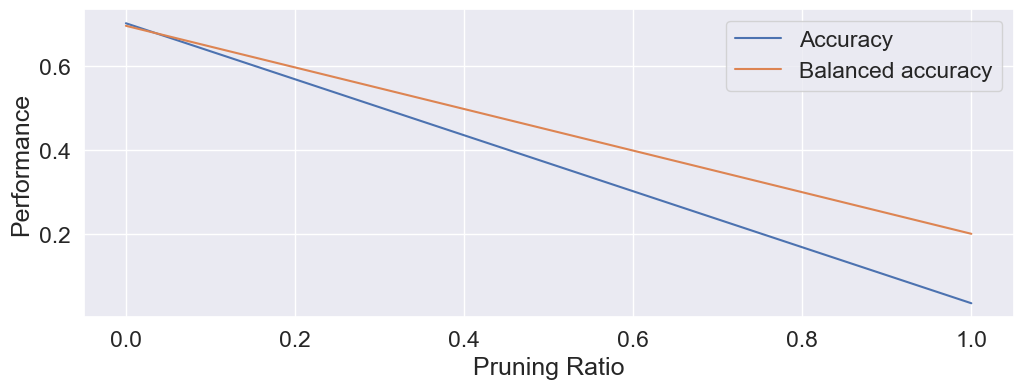

In [106]:
plt.figure(figsize=(12, 4))
plt.plot(pruning_ratios, df['accuracy'], label='Accuracy')
plt.plot(pruning_ratios, df['balanced_acc'], label='Balanced accuracy')

plt.xlabel('Pruning Ratio')
plt.ylabel('Performance')
plt.legend()
plt.show()

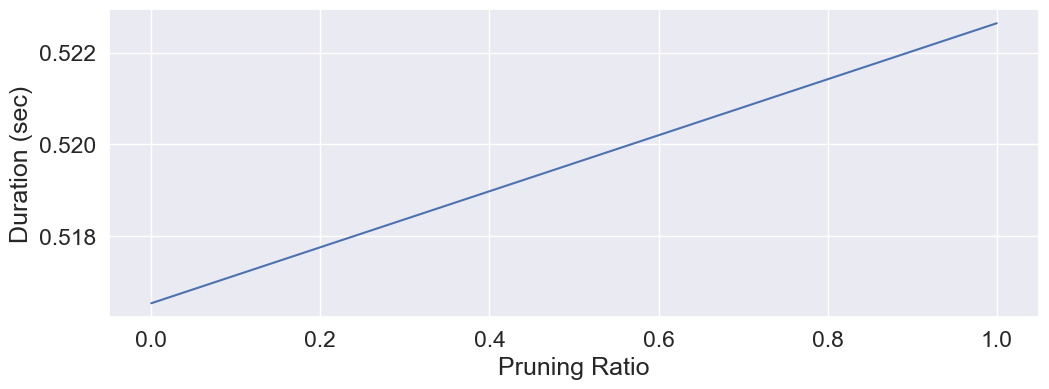

In [110]:
plt.figure(figsize=(12, 4))
plt.plot(pruning_ratios, df['duration'], label='Duration (in sec)')
# plt.plot(pruning_ratios, df['balanced_acc'], label='Balanced accuracy')

plt.xlabel('Pruning Ratio')
plt.ylabel('Duration (in sec)')
# plt.legend()
plt.show()

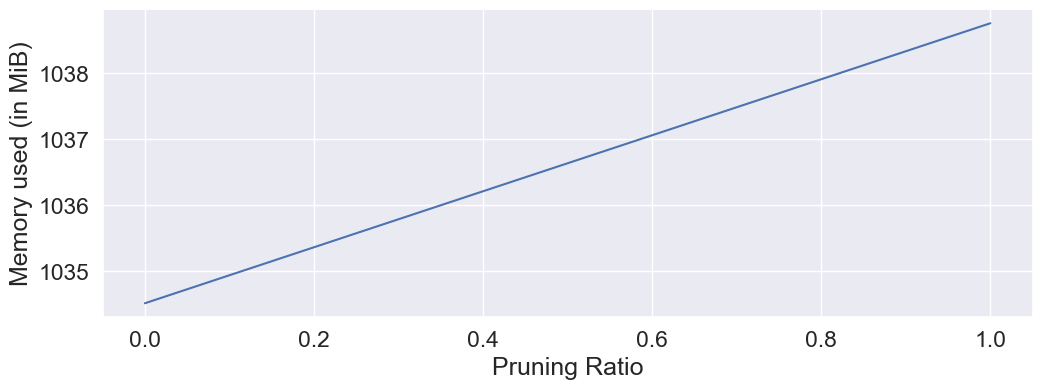

In [111]:
plt.figure(figsize=(12, 4))
plt.plot(pruning_ratios, df['memory_usage'], label = 'Memory used (in MiB)')
# plt.plot(pruning_ratios, df['balanced_acc'], label='Balanced accuracy')

plt.xlabel('Pruning Ratio')
plt.ylabel('Memory used (in MiB)')
#plt.legend()
plt.show()

#### ADDITIONAL: Not used at the moment...

In [ ]:
num_classes     = 5

design_matrix   = lambda x: np.column_stack((np.ones(len(x)), x))
# design_matrix   = lambda x: np.column_stack((np.ones(len(x)), x, x**2))
# design_matrix   = lambda x: np.column_stack((np.ones(len(x)), x, x**2, x**3, x**4))
one_hot_encode  = lambda t: np.eye(num_classes)[t] 

# define softmax
softmax = lambda y: np.exp(y) / np.exp(y).sum(axis=1)[:, np.newaxis]

def predict(Phi: np.ndarray, theta: np.ndarray) -> (np.ndarray, np.ndarray):
    # get latent function value
    y = Phi @ theta
    # get soft probabilty scores
    prob = softmax(y)
    # get topk predictions
    pred = prob.argmax(axis=1)

    return pred, prob

In [91]:
# Create design matrices
Phi_train       = design_matrix(latent_representations_train)
Phi_val         = design_matrix(latent_representations_val)
Phi_test        = design_matrix(latent_representations_test)

# Number of parameters
n_params        = Phi_train.shape[1]

# One-of-K encode targets
ttrain_enc      = one_hot_encode(ttrain)
tval_enc        = one_hot_encode(tval)

# Get least squares solution
theta_hat_LS = np.linalg.solve(Phi_train.T @ Phi_train, Phi_train.T @ ttrain_enc) 

# Get LS predictions 
ttrain_hat_LS, ttrain_prob_LS       = predict(Phi_train, theta_hat_LS)
tval_hat_LS, tval_prob_LS           = predict(Phi_val, theta_hat_LS)

In [92]:
print("\n--- LS ESTIMATE OBTAINED ---")
print(f"Accuracy train: {(ttrain_hat_LS == ttrain).mean():.4f}")
print(f"Accuracy validation: {(tval_hat_LS == tval).mean():.4f}")
print(f"Balanced accuracy train: {balanced_accuracy_score(ttrain, ttrain_hat_LS):.4f}")
print(f"Balanced accuracy validation: {balanced_accuracy_score(tval, tval_hat_LS):.4f}")


--- LS ESTIMATE OBTAINED ---
Accuracy train: 0.9556
Accuracy validation: 0.7823
Balanced accuracy train: 0.9556
Balanced accuracy validation: 0.7860
